# Init

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import multiprocessing
from itertools import repeat, product
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.patheffects as pe
import seaborn as sns
import scipy
from scipy.interpolate import interp1d
import scqubits as scq
import matplotlib as mpl
from datetime import datetime as dt
from sqgbrwa.utils import *
from sqgbrwa.pulse_envelopes import *
from sqgbrwa.magnus_approximation import *
from sqgbrwa.pulse_parameters import *
from sqgbrwa.experiment_simulations import *
from sqgbrwa.time_solvers import *
from sqgbrwa.time_evolutions import *

# Undo settings that scqubits sets
mpl.rcdefaults() 
plt.rcdefaults()
mpl.rcParams['interactive'] = False
plt.rcParams['interactive'] = False

In [2]:
# Ensure font sizes are large enough to read
poster_sizes = [24, 26, 28]
presentation_sizes = [16, 18, 20]
SMALL_SIZE = presentation_sizes[0]
MEDIUM_SIZE = presentation_sizes[1]
BIGGER_SIZE = presentation_sizes[2]

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)

In [3]:
figure_data = dict()
extended_data = dict()

# Plot fluxonium potential

In [ ]:
fluxonium = scq.Fluxonium(EJ=5, 
                          EC=1, 
                          EL=1, 
                          flux=0.5, 
                          cutoff=20, 
                          truncated_dim=20, 
                          id_str="fluxonium")
N = 4
M = 151
phi_grid = scq.core.discretization.Grid1d(-2.5*np.pi, 2.5*np.pi, M)
phis = phi_grid.make_linspace()

In [ ]:
eigensys = fluxonium.eigensys()
potential = fluxonium.potential(phis)

# Rescale energies such that the energy of |0> is 0
energies = eigensys[0]
potential -= energies[0]
energies -= energies[0]

# Define colors for the plot
color_list = [
    "#287763",
    colors['purple'],
    colors['blue'],
    colors['red']
]

fig,ax = plt.subplots(1, 1, figsize=(695/516*3.5, 3.5), dpi=300)
ax.set_xlabel(r"$\phi$ $(\pi)$", fontsize=20)
ax.set_ylabel(r"Re($\psi_j$), $E/h$ (GHz)", fontsize=20)

for i in range(N):
    test = fluxonium.wavefunction(fluxonium.eigensys(), 
                                  which=i,
                                  phi_grid=phi_grid)
    amps = 2*scq.utils.spectrum_utils.standardize_sign(test.amplitudes).real
    ax.plot(phis/np.pi, amps + energies[i], linewidth=2, label=rf"$\psi_{i}$", color=color_list[i], zorder=10-i)
    ax.fill_between(phis/np.pi, energies[i], amps+energies[i], color=color_list[i], lw=0, alpha=0.6, zorder=5-i)

ax.plot(phis/np.pi, potential, linewidth=3, color="#333", alpha=.9)
ax.set_ylim(bottom=-3.1, top=8)
ax.set_yticks([0,4,8])
ax.set_xticks([-2,0,2])
ax.set_xlim(-2.5,2.5)

# Annotate state labels
ax.annotate(text=r"$\vert 0 \rangle$",
            xy=(0,1),
            xytext=(291,87),
            xycoords='figure points',
            fontsize=18,
            color=color_list[0])
ax.annotate(text=r"$\vert 1 \rangle$",
            xy=(0,1),
            xytext=(291,124),
            xycoords='figure points',
            fontsize=18,
            color=color_list[1])
ax.annotate(text=r"$\vert 2 \rangle$",
            xy=(0,1),
            xytext=(291,154),
            xycoords='figure points',
            fontsize=18,
            color=color_list[2])
ax.annotate(text=r"$\vert 3 \rangle$",
            xy=(0,1),
            xytext=(291,191),
            xycoords='figure points',
            fontsize=18,
            color=color_list[3])

# Annotate (b)
fig.tight_layout()
ax.annotate(text=r"(b)",
            xy=(0,1),
            xytext=(1,236),
            xycoords='figure points',
            fontsize=18,
            weight="bold")

fig.savefig("figure-fluxonium.png", dpi=200)

# Figures 0th-order Magnus expansion

## Fidelity wrt RWA evolution with and without correction term as a function of the gate duration

In [ ]:
# Set parameters
wd = 2*np.pi*80e6
phi = 0

In [ ]:
# Set gate durations and init result arrays
# tgs = np.arange(1e-9,100.1e-9,0.1e-9)
tgs = np.arange(0.1,16.01,0.01) * np.pi/wd
fidelity_without_correction = np.zeros(len(tgs))
fidelity_with_numerical_correction = np.zeros(len(tgs))
fidelity_with_analytical_correction = np.zeros(len(tgs))
results_V0 = np.zeros(len(tgs))
results_ppp = np.zeros(len(tgs))

In [ ]:
# Compute fidelity with and without correction term
for i,tg in enumerate(tgs):
    ppp_theory, V0_theory = calculate_theory_pulse_parameters(tg=tg,
                                                              wd=wd,
                                                              beta=0,
                                                              t0=0,
                                                              K=15)
    fidelity_without_correction[i] = magnus0_fidelity(tg=tg, wd=wd, ppp=0)
    fidelity_with_numerical_correction[i] = magnus0_fidelity(tg=tg, wd=wd, ppp=np.pi/tg*ppp_theory, V0=V0_theory)
    fidelity_with_analytical_correction[i] = magnus0_fidelity(tg=tg, wd=wd, ppp=np.pi/tg*1/2/wd, V0=1)
    results_V0[i] = V0_theory
    results_ppp[i] = ppp_theory
    

# The fidelity is slightly larger than 1 due to numerical imprecisions,
# hence we have to clip it to plot the error on a log scale
fidelity_without_correction = np.clip(fidelity_without_correction,0,1-1e-12)
fidelity_with_numerical_correction = np.clip(fidelity_with_numerical_correction,0,1-1e-12)
fidelity_with_analytical_correction = np.clip(fidelity_with_analytical_correction,0,1-1e-12)

In [ ]:
# Make a figure
fig,ax = fig_prepare(r"$t_g$ ($t_c$)", "Error", yscale="log")
ax.plot(tgs*wd/np.pi, 3/2*(1-fidelity_without_correction), color="#f1a226", linewidth=2.5, label="Without correction")
ax.plot(tgs*wd/np.pi, 3/2*(1-fidelity_with_numerical_correction), color="#298c8c", linewidth=2.5, linestyle="--")
ax.plot(tgs*wd/np.pi, 3/2*(1-fidelity_with_analytical_correction), color="#298c8c", linewidth=2.5, label="With correction")

ax.set_xticks([0, 2, 5, 10, 15])
ax.set_ylim([5e-13, 2])
ax.set_yticks([1e-12, 1e-8, 1e-4, 1])

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
ax2.set_xlabel(r"$t_g$ (ns)")
ax2.set_xticks(ticks=np.array([0, 25e-9, 50e-9, 75e-9, 100e-9])*wd/np.pi,
               labels=[0, 25, 50, 75, 100])

fig.legend(loc=[0.54,0.64])
fig.tight_layout()
fig.savefig("magnus0-vs-tg.png", dpi=200)

In [ ]:
# Here, we initialize a list with all the data that 
# we can store later and use to plot stuff
figure_data[0] = dict(
    x=np.copy(tgs),
    y1=np.copy(fidelity_without_correction),
    y2=np.copy(fidelity_with_numerical_correction),
    y3=np.copy(fidelity_with_analytical_correction),
    metadata="Plot of corrected/uncorrected fidelities vs gate duration",
    wd=wd,
)

## Fidelity wrt RWA evolution with and without correction term as a function of time for a certain gate duration

In [ ]:
# Set parameters
tg = 20e-9
wd = 2*np.pi*80e6
phi = 0

# Define pulse envelope
pulse_envelope = CosinePulseEnvelope(tg=tg)

# Calculate V0
V0 = pulse_envelope.V0

# Time steps
# t = np.linspace(0,tg,100000)
N = tg / (np.pi/wd)
t = np.arange(0, N*(1+1/300000), N/200000) * np.pi/wd
print(N, np.max(t*wd/np.pi), len(t))

In [ ]:
# Hamiltonian for RWA evolution
def H_rwa(t):
    return 1/2*V0*pulse_envelope.envelope(t)*sigmax_np

U_rwa = propagator(H_rwa, t0=tg, num_time_steps=len(t), return_all=True)

In [ ]:
# Get time-evolution operator of 0th-order Magnus
# expansion of non-RWA Hamiltonian
U_nonrwa_uncorrected = magnus_expansion_0(tg=tg,
                                          wd=wd,
                                          ppp=0,
                                          t=t,
                                          V0=V0,
                                          phi=0,
                                          return_mode="unitary")

U_nonrwa_corrected = magnus_expansion_0(tg=tg,
                                        wd=wd,
                                        ppp=1/2/wd*np.pi/tg,
                                        t=t,
                                        V0=V0,
                                        phi=0,
                                        return_mode="unitary")

In [ ]:
fidelities_uncorrected = np.zeros(len(t))
fidelities_corrected = np.zeros(len(t))

for i in range(len(t)):
    # Calculate fidelity
    E = U_rwa[i,:,:].conj().T @ U_nonrwa_uncorrected[i,:,:]
    fidelities_uncorrected[i] = (2+np.trace(E)*np.trace(E.conj().T)).real/6
    
    E = U_rwa[i,:,:].conj().T @ U_nonrwa_corrected[i,:,:]
    fidelities_corrected[i] = (2+np.trace(E)*np.trace(E.conj().T)).real/6

In [ ]:
fig,ax = fig_prepare(r"$t$ ($\pi/\omega_d$)", "Error", yscale="log")
ax.plot(t*wd/np.pi, 3/2*(1-fidelities_uncorrected), color="#f1a226", linewidth=2.5, label="Without correction")
ax.plot(t*wd/np.pi, 3/2*(1-fidelities_corrected), color="#298c8c", linewidth=2.5, label="With correction")
ax.set_ylim(bottom=1e-12,top=1.1)
ax.set_xticks([0,1,2,3])
fig.legend(loc=[0.54,0.78])
fig.tight_layout()
fig.savefig("magnus0-vs-t.png", dpi=200)

In [ ]:
# VS beta
betas = np.linspace(0,2*np.pi,81)
results_fidelities_vs_beta = np.zeros(len(betas))
results_V0_vs_beta = np.zeros(len(betas))
results_ppp_vs_beta = np.zeros(len(betas))

for i,beta in enumerate(betas):
    ppp_theory, V0_theory = calculate_theory_pulse_parameters(tg=tg,
                                                              wd=wd,
                                                              beta=beta,
                                                              t0=0,
                                                              K=15)
    results_fidelities_vs_beta[i] = magnus0_fidelity(tg=tg, wd=wd, ppp=np.pi/tg*ppp_theory, V0=V0)
    results_V0_vs_beta[i] = V0_theory
    results_ppp_vs_beta[i] = ppp_theory

In [ ]:
results_fidelities_vs_beta = np.clip(results_fidelities_vs_beta,0,1-1e-12)

In [ ]:
figure_data[1] = dict(
    x=np.copy(t),
    x2=np.copy(betas),
    # Data for in main text
    y1=np.copy(fidelities_uncorrected),
    y2=np.copy(fidelities_corrected),
    # Data for in appendix
    y3=np.copy(results_V0),
    y4=np.copy(results_ppp),
    y5=np.copy(results_fidelities_vs_beta),
    y6=np.copy(results_V0_vs_beta),
    y7=np.copy(results_ppp_vs_beta),
    metadata="Plot of corrected/uncorrected fidelities vs gate duration",
    wd=wd
)

## Heatmap for fixed $\beta$

Here, we compute 3 heatmaps of the gate error as a function of time and carrier phase:
1. For the uncorrected pulse parameters
2. For the approximately corrected pulse parameters and a specific value of $\beta$
3. For the exactly corrected pulse parameters and $\beta=0$

In [ ]:
# Time steps
t = np.linspace(0,tg,1000)

# Hamiltonian for RWA evolution
def H_rwa(t):
    return 1/2*V0*pulse_envelope.envelope(t)*sigmax_np

U_rwa = propagator(H_rwa, t0=tg, num_time_steps=len(t), return_all=True, atol=1e-13, rtol=1e-13)

In [ ]:
# Specify carrier phases and beta
phis = np.arange(0,2.025*np.pi,0.025*np.pi)
beta = np.pi

# Init arrays to store results
fidelities_uncorrected = np.zeros((len(t), len(phis)))
fidelities_corrected_approximate = np.zeros((len(t), len(phis)))
fidelities_corrected_exact = np.zeros((len(t), len(phis)))
V0_theories_constant_beta = np.zeros(len(phis))
drag_theories_constant_beta = np.zeros(len(phis))
t0s = np.zeros(len(phis))

In [ ]:
for i,phi in enumerate(phis):
    t0 = (beta-2*phi)
    while t0<0:
        t0 += 2*np.pi

    t0s[i] = t0/2/wd
    # Calculate correction terms
    # Force t0=0 for the Analytical result
    drag_theory, V0_theory = calculate_theory_pulse_parameters(tg=tg,
                                                               wd=wd,
                                                               beta=beta,
                                                               t0=t0/2/wd,
                                                               K=15)

    drag_theories_constant_beta[i] = drag_theory
    V0_theories_constant_beta[i] = V0_theory
    
    # Get time-evolution operator of 0th-order Magnus
    # expansion of non-RWA Hamiltonian
    U_nonrwa_uncorrected = magnus_expansion_0(tg=tg,
                                             wd=wd,
                                             ppp=0,
                                             t=t,
                                             V0=V0,
                                             phi=phi,
                                             return_mode="unitary")

    U_nonrwa_corrected_approximate = magnus_expansion_0(tg=tg,
                                                        wd=wd,
                                                        ppp=drag_theory*np.pi/tg,
                                                        t=t,
                                                        V0=V0*V0_theory,
                                                        phi=phi,
                                                        return_mode="unitary")
    
    U_nonrwa_corrected_exact = magnus_expansion_0(tg=tg,
                                                  wd=wd,
                                                  ppp=1/2/wd*np.pi/tg,
                                                  t=t,
                                                  V0=V0,
                                                  phi=phi,
                                                  return_mode="unitary")

    for j in range(len(t)):
        # Calculate fidelity
        E = U_rwa[j,:,:].conj().T @ U_nonrwa_uncorrected[j,:,:]
        fidelities_uncorrected[j,i] = (2+np.trace(E)*np.trace(E.conj().T)).real/6
        
        E = U_rwa[j,:,:].conj().T @ U_nonrwa_corrected_approximate[j,:,:]
        fidelities_corrected_approximate[j,i] = (2+np.trace(E)*np.trace(E.conj().T)).real/6

        E = U_rwa[j,:,:].conj().T @ U_nonrwa_corrected_exact[j,:,:]
        fidelities_corrected_exact[j,i] = (2+np.trace(E)*np.trace(E.conj().T)).real/6

# The fidelity is slightly larger than 1 due to numerical imprecisions,
# hence we have to clip it to plot the error on a log scale
fidelities_uncorrected = np.clip(fidelities_uncorrected,0,1-1e-12)
fidelities_corrected_approximate = np.clip(fidelities_corrected_approximate,0,1-1e-12)
fidelities_corrected_exact = np.clip(fidelities_corrected_exact,0,1-1e-12)

In [ ]:
# Plot heatmap 1
fig,ax = fig_prepare("x", "y")
ax = sns.heatmap(np.flip(3/2*(1-fidelities_uncorrected).T, axis=0), xticklabels=t*1e9, yticklabels=np.round(np.flip(phis/np.pi),2), cmap="viridis", cbar_kws={"label": "Error"}, ax=ax, norm=LogNorm())

xx_interp = interp1d(t, np.arange(len(t)))
yy_interp = interp1d(phis, len(phis) - np.arange(len(phis)))

x_vals = np.array([0, 1, 2, 3])*np.pi/wd
y_vals = np.array([0, 0.5, 1, 1.5, 2])*np.pi

ax.set_xticks([0.5+i for i in xx_interp(x_vals)])
ax.set_yticks([-0.5+i for i in yy_interp(y_vals)])
ax.set(xlabel=r"$t$ ($\pi/\omega_d$)", ylabel=r"Carrier phase $\phi$ ($\pi$)")
ax.set_xticklabels(np.round(x_vals*wd/np.pi).astype(int), rotation=0)
ax.set_yticklabels(np.round(y_vals/np.pi, 2))

fig.tight_layout()

In [ ]:
# Plot heatmap 2
fig,ax = fig_prepare("x", "y")
ax = sns.heatmap(np.flip(3/2*(1-fidelities_corrected_approximate).T, axis=0), xticklabels=t*1e9, yticklabels=np.round(np.flip(phis/np.pi),2), cmap="viridis", cbar_kws={"label": "Error"}, ax=ax, norm=LogNorm())

xx_interp = interp1d(t, np.arange(len(t)))
yy_interp = interp1d(phis, len(phis) - np.arange(len(phis)))

x_vals = np.array([0, 1, 2, 3])*np.pi/wd
y_vals = np.array([0, 0.5, 1, 1.5, 2])*np.pi

ax.set_xticks([0.5+i for i in xx_interp(x_vals)])
ax.set_yticks([-0.5+i for i in yy_interp(y_vals)])
ax.set(xlabel=r"$t$ ($\pi/\omega_d$)", ylabel=r"Carrier phase $\phi$ ($\pi$)")
ax.set_xticklabels(np.round(x_vals*wd/np.pi).astype(int), rotation=0)
ax.set_yticklabels(np.round(y_vals/np.pi, 2))

for n in range(5):
    _min = max([0, (beta/2+n*np.pi-2*np.pi)/wd])
    _max = min([beta/2/wd+n*np.pi/wd,t[-1]])
    
    if _min==_max:
        continue

    xx = np.linspace(_min,_max,3)
    ax.plot(xx_interp(xx)+0.5, yy_interp(beta/2 + n*np.pi-wd*xx)-0.5, linestyle=(0, (5, 10)), color="#CC0000", linewidth=2.3)

fig.tight_layout()

In [ ]:
# Plot heatmap 3
fig,ax = fig_prepare("x", "y")
ax = sns.heatmap(np.flip(3/2*(1-fidelities_corrected_exact).T, axis=0), xticklabels=t*1e9, yticklabels=np.round(np.flip(phis/np.pi),2), cmap="viridis", cbar_kws={"label": "Error"}, ax=ax, norm=LogNorm())

xx_interp = interp1d(t, np.arange(len(t)))
yy_interp = interp1d(phis, len(phis) - np.arange(len(phis)))

x_vals = np.array([0, 1, 2, 3])*np.pi/wd
y_vals = np.array([0, 0.5, 1, 1.5, 2])*np.pi

ax.set_xticks([0.5+i for i in xx_interp(x_vals)])
ax.set_yticks([-0.5+i for i in yy_interp(y_vals)])
ax.set(xlabel=r"$t$ ($\pi/\omega_d$)", ylabel=r"Carrier phase $\phi$ ($\pi$)")
ax.set_xticklabels(np.round(x_vals*wd/np.pi).astype(int), rotation=0)
ax.set_yticklabels(np.round(y_vals/np.pi, 2))

for n in range(6):
    _min = max([0, (n*np.pi-2*np.pi)/wd])
    _max = min([n*np.pi/wd,t[-1]])
    
    if _min==_max:
        continue

    xx = np.linspace(_min,_max,3)
    ax.plot(xx_interp(xx)+0.5, yy_interp(n*np.pi-wd*xx)-0.5, linestyle=(0, (5, 10)), color="#CC0000", linewidth=2.3)

fig.tight_layout()

In [ ]:
fig,ax = fig_prepare(r"$\phi$ ($\pi$)", "DRAG theory")
ax.plot(phis/np.pi, drag_theories_constant_beta*wd, color=colors["blue"], linewidth=2)
ax2 = ax.twinx()
ax2.plot(phis/np.pi, V0_theories_constant_beta, color=colors["red"], linewidth=2)

# ax.set_yticks([-1,-0.5,0,0.5])
ax.set_ylabel(r"DRAG param ($1/\omega_d$)")
ax2.set_ylabel("V0 (a.u.)")
ax.yaxis.label.set_color(colors["blue"])
ax2.yaxis.label.set_color(colors["red"])
fig.tight_layout()
fig.savefig("gauge-params.png", dpi=200)

## Heatmap for varying $\beta$, constant $t_0=0$

Heatmap of gate fidelity as a function of time and carrier phase for a varying beta but fixing $t_0=0$ for all $\phi$

In [ ]:
# We have to run this with the same parameters as the above section
fidelities_corrected_varying_beta = np.zeros((len(t), len(phis)))
V0_theories_varying_beta = np.zeros(len(phis))
drag_theories_varying_beta = np.zeros(len(phis))
betas_varying_beta = np.zeros(len(phis))

In [ ]:
for i,phi in enumerate(phis):
    # tc = np.pi/wd
    # N = np.floor(tg/tc).astype(int)
    # t0 = (tg-N*tc)/2
    t0 = 0

    # Calculate correction terms
    beta = 2*phi + 2*wd*t0
    betas_varying_beta[i] = beta
    drag_theory, V0_theory = calculate_theory_pulse_parameters(tg=tg,
                                                               wd=wd,
                                                               beta=beta,
                                                               K=15,
                                                               t0=t0)

    drag_theories_varying_beta[i] = drag_theory
    V0_theories_varying_beta[i] = V0_theory

    # Get time-evolution operator of 0th-order Magnus
    # expansion of non-RWA Hamiltonian
    U_nonrwa_corrected = magnus_expansion_0(tg=tg,
                                            wd=wd,
                                            ppp=drag_theory*np.pi/tg,
                                            t=t,
                                            V0=V0*V0_theory,
                                            phi=phi,
                                            return_mode="unitary")

    for j in range(len(t)):
        # Calculate fidelity
        E = U_rwa[j,:,:].conj().T @ U_nonrwa_corrected[j,:,:]
        fidelities_corrected_varying_beta[j,i] = (2+np.trace(E)*np.trace(E.conj().T)).real/6

# The fidelity is slightly larger than 1 due to numerical imprecisions,
# hence we have to clip it to plot the error on a log scale
fidelities_corrected_varying_beta = np.clip(fidelities_corrected_varying_beta,0,1-1e-12)

In [ ]:
fig,ax = fig_prepare("x", "y")
ax = sns.heatmap(np.flip(3/2*(1-fidelities_corrected_varying_beta).T, axis=0), xticklabels=t*1e9, yticklabels=np.round(np.flip(phis/np.pi),2), cmap="viridis", cbar_kws={"label": "Error"}, ax=ax, norm=LogNorm())

xx_interp = interp1d(t, np.arange(len(t)))
yy_interp = interp1d(phis, len(phis) - np.arange(len(phis)))

x_vals = np.array([0, 1, 2, 3])*np.pi/wd
y_vals = np.array([0, 0.5, 1, 1.5, 2])*np.pi

ax.set_xticks([0.5+i for i in xx_interp(x_vals)])
ax.set_yticks([-0.5+i for i in yy_interp(y_vals)])
ax.set(xlabel=r"$t$ ($\pi/\omega_d$)", ylabel=r"Carrier phase $\phi$ ($\pi$)")
ax.set_xticklabels(np.round(x_vals*wd/np.pi).astype(int), rotation=0)
ax.set_yticklabels(np.round(y_vals/np.pi, 2))

# fig.set_size_inches((8,7*8/8.7))
fig.tight_layout()
fig.savefig("magnus0-gauge-corrected.png", dpi=200)

In [ ]:
fig,ax = fig_prepare("x","y",yscale="log")
ax.plot(phis/np.pi, 3/2*(1-fidelities_corrected_varying_beta[-1,:]))

fig,ax = fig_prepare("x","y")
ax.plot(phis/np.pi, np.mod(betas_varying_beta,2*np.pi)/np.pi)

In [ ]:
fig,ax = fig_prepare(r"$\phi$ ($\pi$)", "DRAG theory")
ax.plot(phis/np.pi, drag_theories_varying_beta*wd, color=colors["blue"], linewidth=2)
ax2 = ax.twinx()
ax2.plot(phis/np.pi, V0_theories_varying_beta, color=colors["red"], linewidth=2)

# ax.set_yticks([-1,-0.5,0,0.5])
ax.set_ylabel(r"DRAG param ($1/\omega_d$)")
ax2.set_ylabel("V0 (a.u.)")
ax.yaxis.label.set_color(colors["blue"])
ax2.yaxis.label.set_color(colors["red"])
fig.tight_layout()
fig.savefig("gauge-params.png", dpi=200)

In [ ]:
figure_data[2] = dict(
    x1=np.copy(t),
    x2=np.copy(phis),
    y1=np.copy(fidelities_uncorrected),
    y2=np.copy(fidelities_corrected_approximate),
    y3=np.copy(fidelities_corrected_exact),
    y4=np.copy(fidelities_corrected_varying_beta),
    z1=np.copy(V0_theories_constant_beta),
    z2=np.copy(drag_theories_constant_beta),
    z3=np.copy(V0_theories_varying_beta),
    z4=np.copy(drag_theories_varying_beta),
    z5=np.copy(t0s),
    metadata="Heatmap of corrected vs uncorrected fidelity vs time and carrier phase for beta=0",
    wd=wd,
)

# 1st order vs full optimized pulse parameters

In [ ]:
# The optimizer optimizes for all these values of phi at the same time
n = 12
phis = [i*np.pi/n for i in range(n)]

# Setpoints
w01 = 2*np.pi*80e6
wd = 2*np.pi*80e6
tgs = np.arange(2, 16.05, 0.05) * np.pi/wd

In [ ]:
# Calculate uncorrected errors
results_fidelity_uncorrected_numerical = np.zeros((len(tgs), len(phis)))
results_fidelity_uncorrected_full      = np.zeros((len(tgs), len(phis)))

for i,tg in enumerate(tgs):
    pulse_envelope = CosinePulseEnvelope(tg=tg)
    V0 = pulse_envelope.V0
    for j,phi in enumerate(phis):
        U1 = magnus_expansion_1_tg(tg=tg,
                                   wd=w01,
                                   ppp=0,
                                   V0=V0,
                                   detuning=0,
                                   phi=phi,
                                   return_mode="unitary")
        E1 = sigmax_np.conj().T @ U1
        results_fidelity_uncorrected_numerical[i,j] = (2+np.trace(E1)*np.trace(E1.conj().T)).real/6

        H2 = H_full_tls(tg=tg,
                        w01=w01,
                        wd=w01,
                        ppp=0,
                        V0=V0,
                        pulse_envelope=pulse_envelope,
                        carrier_phase=phi)
        U2 = propagator(H2, t0=tg, num_time_steps=10000, return_all=False)
        E2 = sigmax_np.conj().T @ U2
        results_fidelity_uncorrected_full[i,j] = (2+np.trace(E2)*np.trace(E2.conj().T)).real/6

In [ ]:
errors_uncorrected_numerical = np.clip(3/2*(1-results_fidelity_uncorrected_numerical), 1e-12, 1)
errors_uncorrected_full = np.clip(3/2*(1-results_fidelity_uncorrected_full), 1e-12, 1)

In [ ]:
fig,ax = fig_prepare("tg", "error", yscale="log")
ax.plot(tgs*1e9, np.mean(errors_uncorrected_numerical, axis=-1), linewidth=2, color="#f1a226")
ax.plot(tgs*1e9, np.mean(errors_uncorrected_full, axis=1), linewidth=2, color="#298c8c")
ax.fill_between(tgs*1e9, np.min(errors_uncorrected_numerical, axis=-1), np.max(errors_uncorrected_numerical, axis=-1), color="#f1a226", alpha=0.5)
ax.fill_between(tgs*1e9, np.min(errors_uncorrected_full, axis=-1), np.max(errors_uncorrected_full, axis=-1), color="#298c8c", alpha=0.5)

In [ ]:
# Placeholder for theory results
results_V0_theory = np.zeros(len(tgs))
results_ppp_theory = np.zeros(len(tgs))
results_delta_theory = np.zeros(len(tgs))

# Placeholder for numerical results
results_V0_numerical = np.zeros(len(tgs))
results_ppp_numerical = np.zeros(len(tgs))
results_delta_numerical = np.zeros(len(tgs))
results_fidelity_numerical = np.zeros((len(tgs), len(phis)))

# Placeholder for full results
results_V0_full = np.zeros(len(tgs))
results_ppp_full = np.zeros(len(tgs))
results_delta_full = np.zeros(len(tgs))
results_fidelity_full = np.zeros((len(tgs), len(phis)))

### Compute theory results

In [ ]:
initial_guess_placeholder = []
V0_bound_placeholder = np.zeros(len(tgs))
ppp_bound_placeholder = np.zeros(len(tgs))
delta_bound_placeholder = np.zeros(len(tgs))
sympy_integrals = analytical_detuning_sympy_functions(K=30)

In [ ]:
for i,tg in enumerate(tgs):
    pulse_envelope = CosinePulseEnvelope(tg=tg)

    # Calculate theoretical pulse params
    results_ppp_theory[i], results_V0_theory[i] = calculate_theory_pulse_parameters(tg=tg,
                                                                                       wd=wd,
                                                                                       beta=0,
                                                                                       t0=0,
                                                                                       K=20)
    results_delta_theory[i] = calculate_theoretical_detuning(wd=w01,
                                                             tg=tg,
                                                             ppp=results_ppp_theory[i],
                                                             V0=pulse_envelope.V0*results_V0_theory[i],
                                                             beta=0,
                                                             t0=0,
                                                             sympy_integrals=sympy_integrals)

    # 1st order correction to V0
    _wd = w01-results_delta_theory[i]
    _tc = np.pi/_wd
    Nc = np.floor(tg/_tc).astype(int)

    F = 1/4/np.pi * (2*np.pi*Nc*_tc - tg*np.sin(2*np.pi*Nc*_tc/tg))

    num = results_delta_theory[i] * results_ppp_theory[i] * (
        1/4/np.pi * (2*np.pi*Nc*_tc - tg*np.sin(2*np.pi*Nc*_tc/tg)) -
        Nc*_tc/2 * (pulse_envelope.envelope(Nc*_tc))
    )
    results_V0_theory[i] = F/(F+num)

    # Check NaN
    if np.isnan(results_V0_theory[i]):
        results_V0_theory[i] = 1

    # Compute initial guess and bounds for numerical optimization
    V0_bound = 0.5
    ppp_bound = 1
    delta_bound = 20
    x0s = []
    if tg>35e-9:
        for x in [results_V0_theory[i]]:
            for y in [results_delta_theory[i]*1e-6/2/np.pi]:
                for z in [results_ppp_theory[i]*np.pi/tg, 1.01*results_ppp_theory[i]*np.pi/tg]:
                    x0s.append([x,y,z])
    elif tg>20e-9:
        for x in [results_V0_theory[i]]:
            for y in [0.9*results_delta_theory[i]*1e-6/2/np.pi, results_delta_theory[i]*1e-6/2/np.pi/2]:
                for z in [results_ppp_theory[i]*np.pi/tg, 1.01*results_ppp_theory[i]*np.pi/tg]:
                    x0s.append([x,y,z])
    elif tg>=10e-9:
        for x in [1, 1.15]:
            for y in [-results_delta_theory[i]*1e-6/2/np.pi, -25, -40]:
                for z in [0.5, 0.7, 0.9]:
                    x0s.append([x,y,z])
            delta_bound = 80
    elif tg>5e-9:
        for x in [results_V0_theory[i], 1.5]:
            for y in [-100, -20]:
                for z in [results_ppp_theory[i]*np.pi/tg]:
                    x0s.append([x,y,z])
        V0_bound = 1
        ppp_bound = 3
        delta_bound = 300
    else:
        for x in [1.4]:
            for y in [-600, -300]:
                for z in [results_ppp_theory[i]*np.pi/tg, 0.5]:
                    x0s.append([x,y,z])
        V0_bound = 1.9
        ppp_bound = 20
        delta_bound = 1100

    initial_guess_placeholder.append(x0s)
    V0_bound_placeholder[i] = V0_bound
    ppp_bound_placeholder[i] = ppp_bound
    delta_bound_placeholder[i] = delta_bound

### Numerical 1st order results

In [ ]:
# Prepare arguments to pass to multiprocessing Pool
args_iter = repeat([])
base_arguments = dict(
    w01=w01,
    phis=phis,
    tol=1e-15,
)

kwargs_iter = [
    {**base_arguments, 
     'tg': tg, 
     't': tg,
     'V0_bound': V0_bound,
     'ppp_bound': ppp_bound,
     'fd_bound': delta_bound,
     'x0s': x0s,} for tg,x0s,V0_bound,ppp_bound,delta_bound in zip(tgs, 
                                                                      initial_guess_placeholder,
                                                                      V0_bound_placeholder,
                                                                      ppp_bound_placeholder,
                                                                      delta_bound_placeholder)
]

In [ ]:
# Execute Pool
pool = multiprocessing.Pool(processes=6)
results = starmap_with_kwargs(pool, optimize_1st_order, args_iter, kwargs_iter)
pool.close()
pool.join()

In [ ]:
for i,result in enumerate(results):
    results_fidelity_numerical[i,:] = result[1]
    results_V0_numerical[i] = result[0]["x"][0]
    results_delta_numerical[i] = result[0]["x"][1]
    results_ppp_numerical[i] = result[0]["x"][2]

### Numerical full results

In [ ]:
# Generate x0's
initial_guess_placeholder = []
V0_bound_placeholder = np.zeros(len(tgs))
ppp_bound_placeholder = np.zeros(len(tgs))
delta_bound_placeholder = np.zeros(len(tgs))
for i,tg in enumerate(tgs):
    x0s = []
    if tg>35e-9:
        for x in [1.89*results_delta_theory[i]*1e-6/2/np.pi, 1.94*results_delta_theory[i]*1e-6/2/np.pi]:
            for y in [results_ppp_theory[i]*np.pi/tg, 1.005*results_ppp_theory[i]*np.pi/tg]:
                for z in [results_V0_theory[i]]:
                    x0s.append([x,y,z])
    
        V0_bound = 0.5
        ppp_bound = 1
        delta_bound = 20
    elif tg>20e-9:
        for x in [1.94*results_delta_theory[i]*1e-6/2/np.pi, 1.89*results_delta_theory[i]*1e-6/2/np.pi]:
            for y in [results_ppp_theory[i]*np.pi/tg, 1.005*results_ppp_theory[i]*np.pi/tg]:
                for z in [results_V0_theory[i]]:
                    x0s.append([x,y,z])
    
        V0_bound = 0.5
        ppp_bound = 1
        delta_bound = 20
    elif tg>=10e-9:
        x0s = []
        for x in [-50, -20]:
            for y in [-0.25*np.pi/tg*1/2/(w01+2*np.pi*30e6), -0.75*np.pi/tg*1/2/(w01+2*np.pi*30e6)]:
                for z in [0.8, 1]:
                    x0s.append([x,y,z])

        V0_bound = 1
        ppp_bound = 1.5
        delta_bound = 100
    else:
        x0s = []
        for x in [-500, -300]:
            for y in [results_ppp_theory[i], -20]:
                for z in [0.2, 0.7]:
                    x0s.append([x,y,z])

        V0_bound = 1.9
        ppp_bound = 100
        delta_bound = 900
        
    initial_guess_placeholder.append(x0s)
    V0_bound_placeholder[i] = V0_bound
    ppp_bound_placeholder[i] = ppp_bound
    delta_bound_placeholder[i] = delta_bound

In [ ]:
# Prepare arguments to pass to multiprocessing Pool
args_iter = repeat([])
base_arguments = dict(
    w01=w01,
    carrier_phases=phis,
    num_time_steps=10000,
    tol=1e-15
)

kwargs_iter = [
    {**base_arguments, 
     'tg': tg, 
     'V0_bound': V0_bound,
     'ppp_bound': ppp_bound,
     'fd_bound': delta_bound,
     'x0s': x0s,} for tg,x0s,V0_bound,ppp_bound,delta_bound in zip(tgs, 
                                                                   initial_guess_placeholder,
                                                                   V0_bound_placeholder,
                                                                   ppp_bound_placeholder,
                                                                   delta_bound_placeholder)
]

In [ ]:
# Execute Pool
pool = multiprocessing.Pool(processes=6)
results = starmap_with_kwargs(pool, ideal_pulse_parameters_propagator_carrier_phase, args_iter, kwargs_iter)
pool.close()
pool.join()

In [ ]:
for i,result in enumerate(results):
    results_fidelity_full[i,:] = result[1]
    results_delta_full[i] = result[0]["x"][0]
    results_ppp_full[i] = result[0]["x"][1]
    results_V0_full[i] = result[0]["x"][2]

### Add to figure_data

In [ ]:
# Store figure data
figure_data[3] = dict(
    x1=tgs,
    x2=phis,
    y1=results_V0_theory,
    y2=results_ppp_theory,
    y3=results_delta_theory,
    y4=results_V0_numerical,
    y5=results_ppp_numerical,
    y6=results_delta_numerical,
    y7=results_fidelity_numerical,
    y8=results_V0_full,
    y9=results_ppp_full,
    y10=results_delta_full,
    y11=results_fidelity_full,
    y12=results_fidelity_uncorrected_numerical,
    y13=results_fidelity_uncorrected_full,
    w01=w01,
    metadata="Optimized pulse parameters for 1st order Magnus approximation and full time evolution"
)

### Recalculate theory parameters

In [ ]:
tgs_iter = figure_data[3]["x1"]
w01 = figure_data[3]["w01"]
betas = 2*np.pi*np.array([x/12 for x in range(12)])

iter_obj = product(tgs_iter, betas)

# Prepare arguments to pass to multiprocessing Pool
args_iter = repeat([])
base_arguments = dict(
    w01=w01,
    method="comm",
)

kwargs_iter = [
    {**base_arguments, 
     'tg': tg, 
     'beta': beta} for tg,beta in iter_obj
]

In [ ]:
# Execute Pool (9m)
pool = multiprocessing.Pool(processes=38)
results = starmap_with_kwargs(pool, calculate_theoretical_pulse_parameters_comm, args_iter, kwargs_iter)
pool.close()
pool.join()

In [ ]:
results_V0_closed_form_comm = np.zeros((len(tgs_iter),len(betas)))
results_ppp_closed_form_comm = np.zeros((len(tgs_iter),len(betas)))
results_detuning_closed_form_comm = np.zeros((len(tgs_iter),len(betas)))

for i,tg in enumerate(tgs_iter):
    for j,beta in enumerate(betas):
        idx = i*len(betas) + j
        results_V0_closed_form_comm[i,j] = results[idx][0]
        results_ppp_closed_form_comm[i,j] = results[idx][1]
        results_detuning_closed_form_comm[i,j] = results[idx][2]

In [11]:
figure_data[3]["y17"] = results_V0_closed_form_comm
figure_data[3]["y18"] = results_ppp_closed_form_comm
figure_data[3]["y19"] = results_detuning_closed_form_comm

# Modelling a FX as a TLS

In [ ]:
EJ = 5
EL = 1
ECs = np.linspace(0.5, 1.5, 31)
tgs = np.arange(10e-9,101e-9,2.5e-9)

In [ ]:
# Fluxonium setpoints
w01s = np.zeros(len(ECs))
alpha2s = np.zeros(len(ECs))
alpha3s = np.zeros(len(ECs))
mat_elems_list = []

for i,EC in enumerate(ECs):
    fluxonium = scq.Fluxonium(EJ=EJ, 
                              EC=EC, 
                              EL=EL, 
                              flux=0.5, 
                              cutoff=30, 
                              truncated_dim=30)
    E = fluxonium.eigenvals()

    w01 = (E[1]-E[0])*1e9*2*np.pi
    w02 = (E[2]-E[0])*1e9*2*np.pi
    w03 = (E[3]-E[0])*1e9*2*np.pi
    w01s[i] = w01
    alpha2s[i] = w02-2*w01
    alpha3s[i] = w03-3*w01

    eta12 = np.abs(fluxonium.matrixelement_table("n_operator")[1,2])/np.abs(fluxonium.matrixelement_table("n_operator")[0,1])
    eta03 = np.abs(fluxonium.matrixelement_table("n_operator")[0,3])/np.abs(fluxonium.matrixelement_table("n_operator")[0,1])
    eta23 = np.abs(fluxonium.matrixelement_table("n_operator")[2,3])/np.abs(fluxonium.matrixelement_table("n_operator")[0,1])

    mat_elems = np.array([[0,1,0,eta03],
                          [1,0,eta12,0],
                          [0,eta12,0,eta23],
                          [eta03,0,eta23,0]])
    mat_elems_list.append(mat_elems)

In [ ]:
iter_obj = list(product(tgs, zip(w01s, alpha2s, alpha3s, mat_elems_list)))
iter_obj = [(x[0], *x[1]) for x in iter_obj]

In [ ]:
args_iter = repeat([])
base_arguments = dict(
    num_phases=1
)
kwargs_iter = [
    {**base_arguments,
     'tg': tg,
     'w01': w01,
     'wd': w01,
     'alpha2': alpha2,
     'alpha3': alpha3,
     'mat_elems': mat_elems} for tg,w01,alpha2,alpha3,mat_elems in iter_obj
]

In [ ]:
pool = multiprocessing.Pool(processes=6)
results = starmap_with_kwargs(pool, optimize_omega_delta_for_tls, args_iter, kwargs_iter)
pool.close()
pool.join()

In [ ]:
results_errors = np.zeros((len(tgs), len(ECs)))
results_errors_uncorrected = np.zeros((len(tgs), len(ECs)))
results_param1 = np.zeros((len(tgs), len(ECs)))
results_errors_uncorrected = np.zeros((len(tgs), len(ECs)))
results_param2 = np.zeros((len(tgs), len(ECs)))
for i,tg in enumerate(tgs):
    for j,EC in enumerate(ECs):
        result = results[i*len(ECs)+j]
        results_errors[i,j] = result[1]
        results_errors_uncorrected[i,j] = result[2]
        results_param1[i,j] = result[0][0]
        results_param2[i,j] = result[0][1]

In [ ]:
results_fidelity_double = np.zeros((len(tgs), len(ECs)))
results_leakage = np.zeros((len(tgs), len(ECs)))
basis_states = [
    np.array([1,0,0,0]).reshape((4,1)), # +z
    np.array([0,1,0,0]).reshape((4,1)), # -z
    1/np.sqrt(2) * np.array([1,1,0,0]).reshape((4,1)), # +x
    1/np.sqrt(2) * np.array([1,-1,0,0]).reshape((4,1)), # -x
    1/np.sqrt(2) * np.array([1,1j,0,0]).reshape((4,1)), # +y
    1/np.sqrt(2) * np.array([1,-1j,0,0]).reshape((4,1)), # -y
]

leakage_states = [
    np.array([0,0,1,0]).reshape((4,1)),
    np.array([0,0,0,1]).reshape((4,1))
]

In [ ]:
# Calculate leakage
for i,tg in enumerate(tgs):
    pulse_envelope = CosinePulseEnvelope(tg=tg)
    for j,EC in enumerate(ECs):
        w01 = w01s[j]
        alpha2 = alpha2s[j]
        alpha3 = alpha3s[j]
        mat_elems = mat_elems_list[j]
        omega_unit = -1/2*(
            mat_elems[0,3]**2/alpha3 -
            mat_elems[1,2]**2/alpha2
        )

        H1 = H_full_tls_tdwd(tg=tg,
                             wd=w01,
                             w01=w01,
                             omega_delta=0,
                             ppp=0,
                             carrier_phase=0,
                             V0=pulse_envelope.V0,
                             pulse_envelope=pulse_envelope)
        U1 = propagator(H1, t0=tg, num_time_steps=10000, U0=np.eye(2, dtype=complex), atol=1e-13, rtol=1e-13)

        H2 = H_full_4_levels(tg=tg,
                             wd=w01,
                             w01=w01,
                             alpha2=alpha2,
                             alpha3=alpha3,
                             mat_elems=mat_elems,
                             omega_delta=results_param2[i,j]*omega_unit,
                             ppp=0,
                             carrier_phase=0,
                             V0=results_param1[i,j]*pulse_envelope.V0,
                             pulse_envelope=pulse_envelope)

        U2 = propagator(H2, t0=tg, num_time_steps=10000, U0=np.eye(4, dtype=complex), atol=1e-13, rtol=1e-13)
        E = U1.conj().T @ U2[:2,:2]
        results_fidelity_double[i,j] = (2+np.trace(E)*np.trace(E.conj().T)).real/6

        for basis_state in basis_states:
            k = U2 @ basis_state
            for leakage_state in leakage_states:
                results_leakage[i,j] += np.trace(np.abs(leakage_state.conj().T @ k))**2 / 6

In [ ]:
# Store in figure data
figure_data[4] = dict(
    x1=tgs,
    x2=ECs,
    y1=results_errors,
    y2=results_param1,
    y3=results_param2,
    y4=results_fidelity_double,
    y5=results_leakage,
    y6=results_errors_uncorrected,
    metadata="Optimized drive strength and time-dependent drive frequency to show an FX can be modeled as a TLS"
)

# Fidelity heatmaps vs PPP and detuning

## Simulate heatmaps

In [ ]:
w01 = 2*np.pi*80e6
gates = ["rx_pi", "rx_pi2"]
tgs = np.array([40e-9, 80e-9])
ppps = np.linspace(-0.75, 0.75, 51)
detunings = np.linspace(-0.5, 0.5, 51)*2*np.pi*1e6

iter_obj = list(product(gates, tgs, ppps, detunings))

In [5]:
# Prepare arguments to pass to multiprocessing Pool
args_iter = repeat([])
base_arguments = dict(
    w01=w01,
    num_phases=12,
    hamiltonian=H_full_tls,
    bound=0.2,
)

kwargs_iter = [
    {**base_arguments, 
     'gate': gate,
     'tg': tg, 
     'ppp': ppp*np.pi/tg*1/2/w01,
     'wd': w01-detuning,} for gate,tg,ppp,detuning in iter_obj
]

In [ ]:
# Execute Pool (919)
pool = multiprocessing.Pool(processes=6)
results = starmap_with_kwargs(pool, optimize_drive_strength_fidelity, args_iter, kwargs_iter)
pool.close()
pool.join()

In [41]:
results_error_pi = np.zeros((len(tgs), len(ppps), len(detunings)))
results_error_pi2 = np.zeros((len(tgs), len(ppps), len(detunings)))
results_V0_pi = np.zeros((len(tgs), len(ppps), len(detunings)))
results_V0_pi2 = np.zeros((len(tgs), len(ppps), len(detunings)))

results_pi = results[:len(results)//2]
results_pi2 = results[len(results)//2:]

for i in range(len(tgs)):
    for j in range(len(ppps)):
        for k in range(len(detunings)):
            idx = i*(len(ppps)*len(detunings)) + j*len(detunings) + k
            results_error_pi[i,j,k] = results_pi[idx][1]
            results_error_pi2[i,j,k] = results_pi2[idx][1]
            results_V0_pi[i,j,k] = results_pi[idx][0][0]
            results_V0_pi2[i,j,k] = results_pi2[idx][0][0]

In [42]:
figure_data[5] = dict(
    x1=tgs,
    x2=ppps,
    x3=detunings,
    y1=results_error_pi[0,...],  # 40 ns
    y2=results_error_pi2[0,...], # 40 ns
    y3=results_error_pi[1,...],  # 100 ns
    y4=results_error_pi2[1,...], # 100 ns
    y5=results_V0_pi[0,...],  # 40 ns
    y6=results_V0_pi2[0,...], # 40 ns
    y7=results_V0_pi[1,...],  # 100 ns
    y8=results_V0_pi2[1,...], # 100 ns
)

## Calculate theory params

In [11]:
tgs_iter = [40e-9, 80e-9]
w01 = 2*np.pi*80e6
N = 31
betas = 2*np.pi*np.array([x/N for x in range(N)])

V0_fracs = [0.5,1]

iter_obj = product(tgs_iter, betas, V0_fracs)

# Prepare arguments to pass to multiprocessing Pool
args_iter = repeat([])
base_arguments = dict(
    w01=w01,
    method="comm",
)

kwargs_iter = [
    {**base_arguments, 
     'tg': tg, 
     'beta': beta,
     'V0_frac': V0_frac} for tg,beta,V0_frac in iter_obj
]


In [ ]:
# Execute Pool (9m)
pool = multiprocessing.Pool(processes=38)
results = starmap_with_kwargs(pool, calculate_theoretical_pulse_parameters, args_iter, kwargs_iter)
pool.close()
pool.join()

In [13]:
results_V0_closed_form_comm = np.zeros((len(tgs_iter),len(betas),len(V0_fracs)))
results_ppp_closed_form_comm = np.zeros((len(tgs_iter),len(betas),len(V0_fracs)))
results_detuning_closed_form_comm = np.zeros((len(tgs_iter),len(betas),len(V0_fracs)))

for i,tg in enumerate(tgs_iter):
    pulse_envelope = CosinePulseEnvelope(tg=tg)
    for j,beta in enumerate(betas):
        for k,V0_frac in enumerate(V0_fracs):
            idx = i*(len(betas)*len(V0_fracs)) + j*len(V0_fracs) + k
            results_V0_closed_form_comm[i,j,k] = np.copy(results[idx][0])
            results_ppp_closed_form_comm[i,j,k] = np.copy(results[idx][1])
            results_detuning_closed_form_comm[i,j,k] = np.copy(results[idx][2])

In [14]:
figure_data[5]["x4"] = betas
figure_data[5]["y9"] =  results_V0_closed_form_comm[:,:,0] # pi2
figure_data[5]["y10"] = results_V0_closed_form_comm[:,:,1] # pi
figure_data[5]["y11"] = results_ppp_closed_form_comm[:,:,0] # pi2
figure_data[5]["y12"] = results_ppp_closed_form_comm[:,:,1] # pi
figure_data[5]["y13"] = results_detuning_closed_form_comm[:,:,0] # pi2
figure_data[5]["y14"] = results_detuning_closed_form_comm[:,:,1] # pi

# Simulations for experiments

## Get qubit params

In [ ]:
# Params FX5
EJ = 4.92281
EL = 0.50083
EC = 0.88049

# Define fluxonium
fluxonium = scq.Fluxonium(EJ=EJ, 
                          EC=EC, 
                          EL=EL, 
                          flux=0.5, 
                          cutoff=30, 
                          truncated_dim=30)

# Get energies
E = fluxonium.eigenvals()
w01 = (0.09897419)*1e9*2*np.pi
w02 = (E[2]-E[0])*1e9*2*np.pi
w03 = (E[3]-E[0])*1e9*2*np.pi
w04 = (E[4]-E[0])*1e9*2*np.pi
w05 = (E[5]-E[0])*1e9*2*np.pi
alpha2 = w02-2*w01
alpha3 = w03-3*w01

# Get matrix elements
eta12 = np.abs(fluxonium.matrixelement_table("n_operator")[1,2])/np.abs(fluxonium.matrixelement_table("n_operator")[0,1])
eta03 = np.abs(fluxonium.matrixelement_table("n_operator")[0,3])/np.abs(fluxonium.matrixelement_table("n_operator")[0,1])
eta23 = np.abs(fluxonium.matrixelement_table("n_operator")[2,3])/np.abs(fluxonium.matrixelement_table("n_operator")[0,1])
eta34 = np.abs(fluxonium.matrixelement_table("n_operator")[3,4])/np.abs(fluxonium.matrixelement_table("n_operator")[0,1])
eta45 = np.abs(fluxonium.matrixelement_table("n_operator")[4,5])/np.abs(fluxonium.matrixelement_table("n_operator")[0,1])
eta05 = np.abs(fluxonium.matrixelement_table("n_operator")[0,5])/np.abs(fluxonium.matrixelement_table("n_operator")[0,1])
eta25 = np.abs(fluxonium.matrixelement_table("n_operator")[2,5])/np.abs(fluxonium.matrixelement_table("n_operator")[0,1])
eta14 = np.abs(fluxonium.matrixelement_table("n_operator")[1,4])/np.abs(fluxonium.matrixelement_table("n_operator")[0,1])

mat_elems = np.array([[0,1,0,eta03],
                      [1,0,eta12,0],
                      [0,eta12,0,eta23],
                      [eta03,0,eta23,0]])
mat_elems2 = np.array([[0,1,0,eta03,0,eta05],
                       [1,0,eta12,0,eta14,0],
                       [0,eta12,0,eta23,0,eta25],
                       [eta03,0,eta23,0,eta34,0],
                       [0,eta14,0,eta34,0,eta45],
                       [eta05,0,eta25,0,eta45,0]])

## Optimize drive strength

In [13]:
tgs = np.array([13.333333e-9, 20e-9, 26.666666e-9, 33.333333e-9, 40e-9])
targets = np.array([0.5,1])
iter_obj = list(product(tgs,targets))

In [ ]:
num_phases = 5

args_iter = repeat([])
# Arguments that are the same for every experiment
base_arguments = dict(
    hamiltonian=H_full_4_levels,
    num_phases=num_phases,
    wd=w01,
    w01=w01,
    alpha2=w02-2*w01,
    alpha3=w03-3*w01,
    mat_elems=mat_elems,
    omega_delta=0
)
# Varying arguments
kwargs_iter = [
    {**base_arguments,
     'tg': tg,
     'target': target} for tg,target in iter_obj
]

In [15]:
pool = multiprocessing.Pool(processes=5)
results = starmap_with_kwargs(pool, optimize_drive_strength, args_iter, kwargs_iter)
pool.close()
pool.join()

In [16]:
results_pi2  = np.zeros(len(tgs))
results_pi   = np.zeros(len(tgs))

for i in range(len(results)//2):
    results_pi2[i]  = results[2*i][0]
    results_pi[i] = results[2*i+1][0][0]

In [ ]:
extended_data["drive_strength_calibration_1"] = dict(
    x0=tgs,
    x1=num_phases,
    y0=results_pi2,
    y1=results_pi
)

In [ ]:
results_fidelity_pi = np.zeros((len(tgs), num_phases))
results_fidelity_pi2 = np.zeros((len(tgs), num_phases))
phases = np.linspace(0,np.pi,num_phases)

for i, tg in enumerate(tgs):
    for j, phase in enumerate(phases):
        pulse_envelope = CosinePulseEnvelope(tg=tg)
        H2 = H_full_4_levels(tg=tg,
                             wd=w01,
                             w01=w01,
                             alpha2=alpha2,
                             alpha3=alpha3,
                             mat_elems=mat_elems,
                             omega_delta=0,
                             ppp=0,
                             carrier_phase=phase,
                             V0=results_pi2[i]*pulse_envelope.V0,
                             pulse_envelope=pulse_envelope)

        U = propagator(H2, t0=tgs[i], num_time_steps=10000, U0=np.eye(4, dtype=complex), atol=1e-13, rtol=1e-13)
        # U_ideal = sigmax_np
        U_ideal = 1/np.sqrt(2) * np.eye(2) - 1j/np.sqrt(2)*sigmax_np
        E = U_ideal.conj().T @ U[:2,:2]
        results_fidelity_pi2[i,j] = (2+np.trace(E)*np.trace(E.conj().T)).real/6

        H2 = H_full_4_levels(tg=tg,
                             wd=w01,
                             w01=w01,
                             alpha2=alpha2,
                             alpha3=alpha3,
                             mat_elems=mat_elems,
                             omega_delta=0,
                             ppp=0,
                             carrier_phase=phase,
                             V0=results_pi[i]*pulse_envelope.V0,
                             pulse_envelope=pulse_envelope)

        U = propagator(H2, t0=tgs[i], num_time_steps=10000, U0=np.eye(4, dtype=complex), atol=1e-13, rtol=1e-13)
        U_ideal = sigmax_np
        E = U_ideal.conj().T @ U[:2,:2]
        results_fidelity_pi[i,j] = (2+np.trace(E)*np.trace(E.conj().T)).real/6

In [ ]:
error_pi = 3/2*(1-np.mean(results_fidelity_pi,axis=-1))
error_pi2 = 3/2*(1-np.mean(results_fidelity_pi2,axis=-1))

fig,ax = fig_prepare("tg", "Error", yscale="log")
ax.plot(tgs*1e9, 1/2*(error_pi+error_pi2), marker=".", markersize=7)
fig.tight_layout()
fig.savefig("mean-error-protocol-1.png", dpi=200)

## Analyse heatmaps

In [8]:
basis_states = [
    np.array([1,0,0,0]).reshape((4,1)), # +z
    np.array([0,1,0,0]).reshape((4,1)), # -z
    1/np.sqrt(2) * np.array([1,1,0,0]).reshape((4,1)), # +x
    1/np.sqrt(2) * np.array([1,-1,0,0]).reshape((4,1)), # -x
    1/np.sqrt(2) * np.array([1,1j,0,0]).reshape((4,1)), # +y
    1/np.sqrt(2) * np.array([1,-1j,0,0]).reshape((4,1)), # -y
]

leakage_states = [
    np.array([0,0,1,0]).reshape((4,1)),
    np.array([0,0,0,1]).reshape((4,1))
]

In [9]:
# Parse data from file into a format we can work with
gates = "x"
evol_idx = 1
if gates=="x":
    time_evolutions_xpi = extended_data[f"time_evolutions_{evol_idx}_xpi"]
    time_evolutions_xmpi = extended_data[f"time_evolutions_{evol_idx}_xmpi"]
    time_evolutions_xpi2 = extended_data[f"time_evolutions_{evol_idx}_xpi2"]
    time_evolutions_xmpi2 = extended_data[f"time_evolutions_{evol_idx}_xmpi2"]
else:
    time_evolutions_xpi = extended_data[f"time_evolutions_{evol_idx}_ypi"]
    time_evolutions_xmpi = extended_data[f"time_evolutions_{evol_idx}_ympi"]
    time_evolutions_xpi2 = extended_data[f"time_evolutions_{evol_idx}_ypi2"]
    time_evolutions_xmpi2 = extended_data[f"time_evolutions_{evol_idx}_ympi2"]

tgs = time_evolutions_xpi["x0"]
wds = time_evolutions_xpi["x2"]
ppps = np.linspace(-0.5,0.5,41)
phases = np.linspace(0,np.pi,41)

unitaries_xpi   = np.zeros((len(tgs), len(wds), len(phases), len(ppps), 4, 4), dtype=complex)
unitaries_xmpi  = np.zeros((len(tgs), len(wds), len(phases), len(ppps), 4, 4), dtype=complex)
unitaries_xpi2  = np.zeros((len(tgs), len(wds), len(phases), len(ppps), 4, 4), dtype=complex)
unitaries_xmpi2 = np.zeros((len(tgs), len(wds), len(phases), len(ppps), 4, 4), dtype=complex)

for i in range(len(tgs)):
    for j in range(len(wds)):
        idx = i*len(wds)+j
        unitaries_xpi[i,j,...]   = time_evolutions_xpi[f"y{idx}"].reshape((len(phases), len(ppps), 4, 4))
        unitaries_xmpi[i,j,...]  = time_evolutions_xmpi[f"y{idx}"].reshape((len(phases), len(ppps), 4, 4))
        unitaries_xpi2[i,j,...]  = time_evolutions_xpi2[f"y{idx}"].reshape((len(phases), len(ppps), 4, 4))
        unitaries_xmpi2[i,j,...] = time_evolutions_xmpi2[f"y{idx}"].reshape((len(phases), len(ppps), 4, 4))

In [10]:
# Here we truncate the data and prepare the interpolation objects
# that serve as the "propagator" function
eye = np.eye(2)
def fit_unitary(U, phi_prev=None):
    U = np.copy(U)
    phi = np.angle(np.trace(eye @ U))

    # Prevent discontinuitites by making sure phi doesn't jump
    # by pi all of a sudden
    if phi_prev is not None:
        if np.abs(phi-phi_prev)>2.9*np.pi:
            phi += np.sign(phi_prev-phi)*np.pi*3
        elif np.abs(phi-phi_prev)>1.9*np.pi:
            phi += np.sign(phi_prev-phi)*np.pi*2
        elif np.abs(phi-phi_prev)>0.9*np.pi:
            phi += np.sign(phi_prev-phi)*np.pi

    # Undo global phase
    U *= np.exp(-1j*phi)

    # Fit unitary
    theta = np.arccos(np.real(np.trace(eye @ U))/2)
    div = (-1j*np.sin(theta))*2
    rx = np.real(np.trace(sigmax_np.conj().T @ U)/div)
    ry = np.real(np.trace(sigmay_np.conj().T @ U)/div)
    rz = np.real(np.trace(sigmaz_np.conj().T @ U)/div)

    return phi,theta,rx,ry,rz


def get_unitary(theta, rx, ry, rz):
    return np.cos(theta)*eye - 1j*np.sin(theta)*(rx*sigmax_np + ry*sigmay_np + rz*sigmaz_np)/np.sqrt(rx**2 + ry**2 + rz**2)

In [11]:
unitaries_xpi_args   = np.zeros((len(tgs), len(wds), len(phases), len(ppps), 5))
unitaries_xmpi_args  = np.zeros((len(tgs), len(wds), len(phases), len(ppps), 5))
unitaries_xpi2_args  = np.zeros((len(tgs), len(wds), len(phases), len(ppps), 5))
unitaries_xmpi2_args = np.zeros((len(tgs), len(wds), len(phases), len(ppps), 5))
leakage_pi = np.zeros((len(tgs), len(wds), len(phases), len(ppps)))
leakage_pi2 = np.zeros((len(tgs), len(wds), len(phases), len(ppps)))

for i in range(len(tgs)):
    for j in range(len(wds)):
        for k in range(len(phases)):
            for l in range(len(ppps)):
                if l==0 and j!=0:
                    unitaries_xpi_args[i,j,k,l,:]   = fit_unitary(unitaries_xpi[i,j,k,l,:2,:2], unitaries_xpi_args[i,j-1,k,0,0])
                    unitaries_xmpi_args[i,j,k,l,:]  = fit_unitary(unitaries_xmpi[i,j,k,l,:2,:2], unitaries_xmpi_args[i,j-1,k,0,0])
                    unitaries_xpi2_args[i,j,k,l,:]  = fit_unitary(unitaries_xpi2[i,j,k,l,:2,:2], unitaries_xpi2_args[i,j-1,k,0,0])
                    unitaries_xmpi2_args[i,j,k,l,:] = fit_unitary(unitaries_xmpi2[i,j,k,l,:2,:2], unitaries_xmpi2_args[i,j-1,k,0,0])
                else:
                    unitaries_xpi_args[i,j,k,l,:]   = fit_unitary(unitaries_xpi[i,j,k,l,:2,:2], unitaries_xpi_args[i,j,k,l-1,0])
                    unitaries_xmpi_args[i,j,k,l,:]  = fit_unitary(unitaries_xmpi[i,j,k,l,:2,:2], unitaries_xmpi_args[i,j,k,l-1,0])
                    unitaries_xpi2_args[i,j,k,l,:]  = fit_unitary(unitaries_xpi2[i,j,k,l,:2,:2], unitaries_xpi2_args[i,j,k,l-1,0])
                    unitaries_xmpi2_args[i,j,k,l,:] = fit_unitary(unitaries_xmpi2[i,j,k,l,:2,:2], unitaries_xmpi2_args[i,j,k,l-1,0])

                # Calculate leakage
                for basis_state in basis_states:
                    k_pi  = unitaries_xpi[i,j,k,l,:,:] @ basis_state
                    k_pi2 = unitaries_xpi2[i,j,k,l,:,:] @ basis_state
                    for leakage_state in leakage_states:
                        leakage_pi[i,j,k,l] += np.trace(np.abs(leakage_state.conj().T @ k_pi))**2 / 6
                        leakage_pi2[i,j,k,l] += np.trace(np.abs(leakage_state.conj().T @ k_pi2))**2 / 6

In [ ]:
deltas = (w01 - wds)*1e-6/2/np.pi
result = np.mean(leakage_pi[2,...], axis=1)

fig,ax = fig_prepare("ppp", r"$\Delta/2\pi$ (MHz)")
ax = sns.heatmap(np.flip(result.T, axis=0), xticklabels=ppps, yticklabels=np.round(np.flip(deltas),2), cmap="Blues", cbar_kws={"label": "Oscillation amplitude"}, ax=ax, norm=LogNorm())

x_interp = interp1d(np.arange(len(ppps)), ppps)
y_interp = interp1d(np.arange(len(deltas)), deltas)

idx = np.linspace(0,len(ppps)-1,5)
idx2 = np.linspace(0,len(deltas)-1,5)

ax.set_xticks([0.5+i for i in idx])
ax.set_yticks([0.5+i for i in idx2])
ax.set(xlabel=r"PPP $\lambda$", ylabel=r"$\Delta/2\pi$ (MHz)")
ax.set_xticklabels(np.round(x_interp(idx), 3), rotation=0)
ax.set_yticklabels(np.round(y_interp(idx2), 2))

fig.tight_layout()
# fig.savefig("heatmap-pi2.png", dpi=200)

In [13]:
# Setpoints for interpolation
setpoints = (wds, phases, ppps)

In [14]:
if gates=="x":
    U_meas = 1/np.sqrt(2) * np.eye(2) - 1j/np.sqrt(2)*sigmay_np
else:
    U_meas = 1/np.sqrt(2) * np.eye(2) - 1j/np.sqrt(2)*sigmax_np
E0 = np.array([[1,0],
               [0,0]])

def simulate_pseudo_identity_interpd(M: list | np.ndarray,
                                     tg: float,
                                     wd: float,
                                     ppp: float,
                                     initial_phase: float,
                                     gate: str = "pi"):
    if gate not in ["pi", "pi2"]:
        raise ValueError("Gate should be pi or pi2")
    if tg not in tgs:
        raise ValueError("Invalid tg")

    # Get index of tg
    tg_idx = np.where(tgs==tg)[0][0]

    # Define data arrays
    if gate=="pi":
        unitaries_plus = unitaries_xpi_args[tg_idx,...]
        unitaries_min = unitaries_xmpi_args[tg_idx,...]
        if gates=="x":
            ideal_gate_plus = sigmax_np
            ideal_gate_min = sigmax_np
        else:
            ideal_gate_plus = sigmay_np
            ideal_gate_min = sigmay_np.conj().T
    else:
        unitaries_plus = unitaries_xpi2_args[tg_idx,...]
        unitaries_min = unitaries_xmpi2_args[tg_idx,...]
        if gates=="x":
            ideal_gate_plus = 1/np.sqrt(2) * np.eye(2) - 1j/np.sqrt(2)*sigmax_np
            ideal_gate_min  = 1/np.sqrt(2) * np.eye(2) + 1j/np.sqrt(2)*sigmax_np
        else:
            ideal_gate_plus = 1/np.sqrt(2) * np.eye(2) - 1j/np.sqrt(2)*sigmay_np
            ideal_gate_min  = 1/np.sqrt(2) * np.eye(2) + 1j/np.sqrt(2)*sigmay_np

    # Carrier phase increment between gates    
    phi_incr = 2*np.pi*tg*wd

    # Prepare points for interp
    points_plus = np.zeros((M[-1], 3))
    points_min  = np.zeros((M[-1], 3))

    # Fill points
    points_plus[:,0] = points_min[:,0] = wd
    points_plus[:,2] = points_min[:,2] = ppp
    points_plus[:,1] = np.mod(initial_phase + 2*np.arange(M[-1]) * phi_incr, np.pi)
    points_min[:,1]  = np.mod(initial_phase + (2*np.arange(M[-1]) + 1) * phi_incr, np.pi)

    # Interp
    params_plus = dict(theta=None, rx=None, ry=None, rz=None)
    params_min  = dict(theta=None, rx=None, ry=None, rz=None)
    for i,param in enumerate(params_plus.keys()):
        params_plus[param] = scipy.interpolate.interpn(points=setpoints, 
                                                       values=unitaries_plus[:,:,:,i+1], 
                                                       xi=points_plus)
        params_min[param]  = scipy.interpolate.interpn(points=setpoints, 
                                                       values=unitaries_min[:,:,:,i+1], 
                                                       xi=points_min)

    # Build unitaries
    unitaries = np.zeros((2*M[-1],2,2), dtype=complex)
    fidelities_plus = np.zeros(M[-1])
    fidelities_min = np.zeros(M[-1])
    for i in range(2*M[-1]):
        if i%2==0:
            unitaries[i,:,:] = get_unitary(theta=params_plus["theta"][i//2],
                                           rx=params_plus["rx"][i//2],
                                           ry=params_plus["ry"][i//2],
                                           rz=params_plus["rz"][i//2])
            # Calculate fidelity
            E = unitaries[i,:,:].conj().T @ ideal_gate_plus
            fidelities_plus[i//2] = (2+np.trace(E)*np.trace(E.conj().T)).real/6
        else:
            unitaries[i,:,:] = get_unitary(theta=params_min["theta"][i//2],
                                           rx=params_min["rx"][i//2],
                                           ry=params_min["ry"][i//2],
                                           rz=params_min["rz"][i//2])

            # Calculate fidelity
            E = unitaries[i,:,:].conj().T @ ideal_gate_min
            fidelities_min[i//2] = (2+np.trace(E)*np.trace(E.conj().T)).real/6

    # Actually simulate the gate sequence
    results = np.zeros(len(M))
    rho = np.array([[1,0],
                    [0,0]])

    for i,m in enumerate(M):
        if i==0:
            for j in range(2*m):
                rho = unitaries[j,:,:] @ rho @ unitaries[j,:,:].conj().T
        else:
            for j in range(2*M[i-1], 2*m):
                rho = unitaries[j,:,:] @ rho @ unitaries[j,:,:].conj().T
        
        results[i] = np.trace(E0 @ U_meas @ rho @ U_meas.conj().T).real

    return results, fidelities_plus, fidelities_min

In [227]:
ppps = np.linspace(-0.5,0.5,31)
deltas = np.linspace(-5,5,31)
wds = w01 - deltas*1e6*2*np.pi
initial_phases = np.linspace(0,np.pi,3)
M = np.arange(1,40,2)
M = np.arange(1,31,2)

results_pi  = np.zeros((len(ppps), len(wds), len(initial_phases), len(M)))
results_pi2 = np.zeros((len(ppps), len(wds), len(initial_phases), len(M)))
fidelities_pi_plus = np.zeros((len(ppps), len(wds), len(initial_phases), M[-1]))
fidelities_pi_min = np.zeros((len(ppps), len(wds), len(initial_phases), M[-1]))
fidelities_pi2_plus = np.zeros((len(ppps), len(wds), len(initial_phases), M[-1]))
fidelities_pi2_min = np.zeros((len(ppps), len(wds), len(initial_phases), M[-1]))

for i,ppp in enumerate(ppps):
    for j,wd in enumerate(wds):
        for k,intial_phase in enumerate(initial_phases):
            results_pi[i,j,k,:], fidelities_pi_plus[i,j,k,:], fidelities_pi_min[i,j,k,:] = simulate_pseudo_identity_interpd(M=M,
                                                                                                                            tg=tgs[1],
                                                                                                                            wd=wd,
                                                                                                                            ppp=ppp,
                                                                                                                            initial_phase=intial_phase,
                                                                                                                            gate="pi")
            results_pi2[i,j,k,:], fidelities_pi2_plus[i,j,k,:], fidelities_pi2_min[i,j,k,:] = simulate_pseudo_identity_interpd(M=M,
                                                                                                                               tg=tgs[1],
                                                                                                                               wd=wd,
                                                                                                                               ppp=ppp,
                                                                                                                               initial_phase=intial_phase,
                                                                                                                               gate="pi2")

In [228]:
# contrasts = np.mean(results, axis=2)
contrasts_pi = results_pi
contrasts_pi2 = results_pi2

contrasts_pi = np.max(contrasts_pi, axis=-1)-np.min(contrasts_pi, axis=-1)
contrasts_pi2 = np.max(contrasts_pi2, axis=-1)-np.min(contrasts_pi2, axis=-1)

In [ ]:
fig,ax = fig_prepare("ppp", r"$\Delta/2\pi$ (MHz)")
ax = sns.heatmap(np.flip(contrasts_pi[:,:,0].T, axis=0), xticklabels=ppps, yticklabels=np.round(np.flip(deltas),2), cmap="Blues", cbar_kws={"label": "Oscillation amplitude"}, ax=ax)

x_interp = interp1d(np.arange(len(ppps)), ppps)
y_interp = interp1d(np.arange(len(deltas)), deltas)

idx = np.linspace(0,len(ppps)-1,5)
idx2 = np.linspace(0,len(deltas)-1,5)

ax.set_xticks([0.5+i for i in idx])
ax.set_yticks([0.5+i for i in idx2])
ax.set(xlabel=r"PPP $\lambda$", ylabel=r"$\Delta/2\pi$ (MHz)")
ax.set_xticklabels(np.round(x_interp(idx), 3), rotation=0)
ax.set_yticklabels(np.round(y_interp(idx2), 2))

fig.tight_layout()
fig.savefig("heatmap-pi.png", dpi=200)

In [ ]:
fig,ax = fig_prepare("ppp", r"$\Delta/2\pi$ (MHz)")
ax = sns.heatmap(np.flip(contrasts_pi2[:,:,0].T, axis=0), xticklabels=ppps, yticklabels=np.round(np.flip(deltas),2), cmap="Blues", cbar_kws={"label": "Oscillation amplitude"}, ax=ax)

x_interp = interp1d(np.arange(len(ppps)), ppps)
y_interp = interp1d(np.arange(len(deltas)), deltas)

idx = np.linspace(0,len(ppps)-1,5)
idx2 = np.linspace(0,len(deltas)-1,5)

ax.set_xticks([0.5+i for i in idx])
ax.set_yticks([0.5+i for i in idx2])
ax.set(xlabel=r"PPP $\lambda$", ylabel=r"$\Delta/2\pi$ (MHz)")
ax.set_xticklabels(np.round(x_interp(idx), 3), rotation=0)
ax.set_yticklabels(np.round(y_interp(idx2), 2))

fig.tight_layout()
fig.savefig("heatmap-pi2.png", dpi=200)

In [ ]:
# intersect = np.square(contrasts_pi2[:,:,0]-contrasts_pi[:,:,0])
intersect1 = np.square(contrasts_pi2[:,:,0] - np.mean(contrasts_pi2[:,:,0]))
intersect2 = np.square(contrasts_pi[:,:,0] - np.mean(contrasts_pi[:,:,0]))
intersect1 = np.max(intersect1)-intersect1
intersect2 = np.max(intersect2)-intersect2
intersect = intersect1*intersect2

fig,ax = fig_prepare("ppp", r"$\Delta/2\pi$ (MHz)")
ax = sns.heatmap(np.flip(intersect.T, axis=0), xticklabels=ppps, yticklabels=np.round(np.flip(deltas),2), cmap="viridis", cbar_kws={"label": "Oscillation amplitude"}, ax=ax, norm=LogNorm())

x_interp = interp1d(np.arange(len(ppps)), ppps)
y_interp = interp1d(np.arange(len(deltas)), deltas)

idx = np.linspace(0,len(ppps)-1,5)
idx2 = np.linspace(0,len(deltas)-1,5)

ax.set_xticks([0.5+i for i in idx])
ax.set_yticks([0.5+i for i in idx2])
ax.set(xlabel=r"$\lambda$", ylabel=r"$\Delta/2\pi$ (MHz)")
ax.set_xticklabels(np.round(x_interp(idx), 3), rotation=0)
ax.set_yticklabels(np.round(y_interp(idx2), 2))

fig.tight_layout()
fig.savefig("heatmap-intersect.png", dpi=200)

In [ ]:
fidelities = np.mean(fidelities_pi_min, axis=-1)
fidelities = np.mean(fidelities, axis=-1)
errors_pi = 3/2 * (1-fidelities)

fig,ax = fig_prepare("ppp", r"$\Delta/2\pi$ (MHz)")
ax = sns.heatmap(np.flip(errors_pi.T, axis=0), xticklabels=ppps, yticklabels=np.round(np.flip(deltas),2), cmap="viridis", cbar_kws={"label": r"Error $\pi$"}, ax=ax, norm=LogNorm())

x_interp = interp1d(np.arange(len(ppps)), ppps)
y_interp = interp1d(np.arange(len(deltas)), deltas)

idx = np.linspace(0,len(ppps)-1,5)
idx2 = np.linspace(0,len(deltas)-1,5)

ax.set_xticks([0.5+i for i in idx])
ax.set_yticks([0.5+i for i in idx2])
ax.set(xlabel=r"$\lambda$", ylabel=r"$\Delta/2\pi$ (MHz)")
ax.set_xticklabels(np.round(x_interp(idx), 3), rotation=0)
ax.set_yticklabels(np.round(y_interp(idx2), 2))

fig.tight_layout()
fig.savefig("heatmap-fidelity-pi.png", dpi=200)

In [ ]:
fidelities = np.mean(fidelities_pi2_min, axis=-1)
fidelities = np.mean(fidelities, axis=-1)
errors_pi2 = 3/2 * (1-fidelities)

fig,ax = fig_prepare("ppp", r"$\Delta/2\pi$ (MHz)")
ax = sns.heatmap(np.flip(errors_pi2.T, axis=0), xticklabels=ppps, yticklabels=np.round(np.flip(deltas),2), cmap="viridis", cbar_kws={"label": r"Error $\pi/2$"}, ax=ax, norm=LogNorm())

x_interp = interp1d(np.arange(len(ppps)), ppps)
y_interp = interp1d(np.arange(len(deltas)), deltas)

idx = np.linspace(0,len(ppps)-1,5)
idx2 = np.linspace(0,len(deltas)-1,5)

ax.set_xticks([0.5+i for i in idx])
ax.set_yticks([0.5+i for i in idx2])
ax.set(xlabel=r"$\lambda$", ylabel=r"$\Delta/2\pi$ (MHz)")
ax.set_xticklabels(np.round(x_interp(idx), 3), rotation=0)
ax.set_yticklabels(np.round(y_interp(idx2), 2))

fig.tight_layout()
fig.savefig("heatmap-fidelity-pi2.png", dpi=200)

In [ ]:
errors = (errors_pi + errors_pi2) / 2

fig,ax = fig_prepare("ppp", r"$\Delta/2\pi$ (MHz)")
ax = sns.heatmap(errors.T, xticklabels=ppps, yticklabels=np.round(np.flip(deltas),2), cmap="viridis", cbar_kws={"label": r"Average gate error"}, ax=ax, norm=LogNorm())

x_interp = interp1d(np.arange(len(ppps)), ppps)
y_interp = interp1d(np.arange(len(deltas)), deltas)

idx = np.linspace(0,len(ppps)-1,5)
idx2 = np.linspace(0,len(deltas)-1,5)

ax.set_xticks([0.5+i for i in idx])
ax.set_yticks([0.5+i for i in idx2])
ax.set(xlabel=r"$\lambda$", ylabel=r"$\Delta/2\pi$ (MHz)")
ax.set_xticklabels(np.round(x_interp(idx), 3), rotation=0)
ax.set_yticklabels(np.round(y_interp(idx2), 2))

fig.tight_layout()
fig.savefig("heatmap-fidelity-total.png", dpi=200)

In [ ]:
ppps = np.linspace(-0.5,0.5,31)
wds = w01 + np.linspace(-5e6,5e6,31)*2*np.pi
num_phases = 12
initial_phases = np.array([i*np.pi/num_phases for i in range(num_phases)])
M = np.arange(1,31,2)

results_pi  = np.zeros((len(tgs), len(ppps), len(wds), len(initial_phases), len(M)))
results_pi2 = np.zeros((len(tgs), len(ppps), len(wds), len(initial_phases), len(M)))
fidelities_pi_plus = np.zeros((len(tgs), len(ppps), len(wds), len(initial_phases), M[-1]))
fidelities_pi_min = np.zeros((len(tgs), len(ppps), len(wds), len(initial_phases), M[-1]))
fidelities_pi2_plus = np.zeros((len(tgs), len(ppps), len(wds), len(initial_phases), M[-1]))
fidelities_pi2_min = np.zeros((len(tgs), len(ppps), len(wds), len(initial_phases), M[-1]))

for l,tg in enumerate(tgs):
    print(f"{l}/{len(tgs)}")
    for i,ppp in enumerate(ppps):
        for j,wd in enumerate(wds):
            for k,intial_phase in enumerate(initial_phases):
                results_pi[l,i,j,k,:], fidelities_pi_plus[l,i,j,k,:], fidelities_pi_min[l,i,j,k,:] = simulate_pseudo_identity_interpd(M=M,
                                                                                                                                      tg=tg,
                                                                                                                                      wd=wd,
                                                                                                                                      ppp=ppp,
                                                                                                                                      initial_phase=intial_phase,
                                                                                                                                      gate="pi")
                results_pi2[l,i,j,k,:], fidelities_pi2_plus[l,i,j,k,:], fidelities_pi2_min[l,i,j,k,:] = simulate_pseudo_identity_interpd(M=M,
                                                                                                                                         tg=tg,
                                                                                                                                         wd=wd,
                                                                                                                                         ppp=ppp,
                                                                                                                                         initial_phase=intial_phase,
                                                                                                                                         gate="pi2")

In [18]:
# Make a lot of figures
deltas = (w01-wds)/2/np.pi*1e-6

for z,tg in enumerate(tgs):
    contrasts_pi  = np.mean(results_pi[z,...], axis=2)
    contrasts_pi2 = np.mean(results_pi2[z,...], axis=2)

    # Average over carrier phases
    contrasts_pi = np.max(contrasts_pi, axis=-1)-np.min(contrasts_pi, axis=-1)
    contrasts_pi2 = np.max(contrasts_pi2, axis=-1)-np.min(contrasts_pi2, axis=-1)

    ## Heatmap pi
    fig,ax = fig_prepare("ppp", r"$\Delta/2\pi$ (MHz)")
    ax = sns.heatmap(contrasts_pi[:,:].T, xticklabels=ppps, yticklabels=np.round(np.flip(deltas),2), cmap="viridis", cbar_kws={"label": "Oscillation amplitude"}, ax=ax)

    x_interp = interp1d(np.arange(len(ppps)), ppps)
    y_interp = interp1d(np.arange(len(deltas)), deltas)

    idx = np.linspace(0,len(ppps)-1,5)
    idx2 = np.linspace(0,len(deltas)-1,5)

    ax.set_xticks([0.5+i for i in idx])
    ax.set_yticks([0.5+i for i in idx2])
    ax.set(xlabel=r"$\lambda$", ylabel=r"$\Delta/2\pi$ (MHz)")
    ax.set_xticklabels(np.round(x_interp(idx), 3), rotation=0)
    ax.set_yticklabels(np.round(y_interp(idx2), 2))

    fig.tight_layout()
    fig.savefig(f"heatmap-pi-{z}.png", dpi=200)

    ## Heatmap pi/2
    fig,ax = fig_prepare("ppp", r"$\Delta/2\pi$ (MHz)")
    ax = sns.heatmap(contrasts_pi2[:,:].T, xticklabels=ppps, yticklabels=np.round(np.flip(deltas),2), cmap="viridis", cbar_kws={"label": "Oscillation amplitude"}, ax=ax)

    x_interp = interp1d(np.arange(len(ppps)), ppps)
    y_interp = interp1d(np.arange(len(deltas)), deltas)

    idx = np.linspace(0,len(ppps)-1,5)
    idx2 = np.linspace(0,len(deltas)-1,5)

    ax.set_xticks([0.5+i for i in idx])
    ax.set_yticks([0.5+i for i in idx2])
    ax.set(xlabel=r"$\lambda$", ylabel=r"$\Delta/2\pi$ (MHz)")
    ax.set_xticklabels(np.round(x_interp(idx), 3), rotation=0)
    ax.set_yticklabels(np.round(y_interp(idx2), 2))

    fig.tight_layout()
    fig.savefig(f"heatmap-pi2-{z}.png", dpi=200)

    ## Heatmap fidelity pi
    fidelities = np.mean(fidelities_pi_plus[z,...], axis=-1)
    fidelities = np.mean(fidelities, axis=-1)
    errors_pi = 3/2 * (1-fidelities)

    fig,ax = fig_prepare("ppp", r"$\Delta/2\pi$ (MHz)")
    ax = sns.heatmap(errors_pi.T, xticklabels=ppps, yticklabels=np.round(np.flip(deltas),2), cmap="viridis", cbar_kws={"label": r"Error $\pi$"}, ax=ax, norm=LogNorm())

    x_interp = interp1d(np.arange(len(ppps)), ppps)
    y_interp = interp1d(np.arange(len(deltas)), deltas)

    idx = np.linspace(0,len(ppps)-1,5)
    idx2 = np.linspace(0,len(deltas)-1,5)

    ax.set_xticks([0.5+i for i in idx])
    ax.set_yticks([0.5+i for i in idx2])
    ax.set(xlabel=r"$\lambda$", ylabel=r"$\Delta/2\pi$ (MHz)")
    ax.set_xticklabels(np.round(x_interp(idx), 3), rotation=0)
    ax.set_yticklabels(np.round(y_interp(idx2), 2))

    fig.tight_layout()
    fig.savefig(f"heatmap-fidelity-pi-{z}.png", dpi=200)

    ## Heatmap fidelity pi/2
    fidelities = np.mean(fidelities_pi2_plus[z,...], axis=-1)
    fidelities = np.mean(fidelities, axis=-1)
    errors_pi2 = 3/2 * (1-fidelities)

    fig,ax = fig_prepare("ppp", r"$\Delta/2\pi$ (MHz)")
    ax = sns.heatmap(errors_pi2.T, xticklabels=ppps, yticklabels=np.round(np.flip(deltas),2), cmap="viridis", cbar_kws={"label": r"Error $\pi/2$"}, ax=ax, norm=LogNorm())

    x_interp = interp1d(np.arange(len(ppps)), ppps)
    y_interp = interp1d(np.arange(len(deltas)), deltas)

    idx = np.linspace(0,len(ppps)-1,5)
    idx2 = np.linspace(0,len(deltas)-1,5)

    ax.set_xticks([0.5+i for i in idx])
    ax.set_yticks([0.5+i for i in idx2])
    ax.set(xlabel=r"$\lambda$", ylabel=r"$\Delta/2\pi$ (MHz)")
    ax.set_xticklabels(np.round(x_interp(idx), 3), rotation=0)
    ax.set_yticklabels(np.round(y_interp(idx2), 2))

    fig.tight_layout()
    fig.savefig(f"heatmap-fidelity-pi2-{z}.png", dpi=200)

    ## Average fidelity
    errors = (errors_pi + errors_pi2) / 2

    fig,ax = fig_prepare("ppp", r"$\Delta/2\pi$ (MHz)")
    ax = sns.heatmap(errors.T, xticklabels=ppps, yticklabels=np.round(np.flip(deltas),2), cmap="viridis", cbar_kws={"label": r"Average gate error"}, ax=ax, norm=LogNorm())

    x_interp = interp1d(np.arange(len(ppps)), ppps)
    y_interp = interp1d(np.arange(len(deltas)), deltas)

    idx = np.linspace(0,len(ppps)-1,5)
    idx2 = np.linspace(0,len(deltas)-1,5)

    ax.set_xticks([0.5+i for i in idx])
    ax.set_yticks([0.5+i for i in idx2])
    ax.set(xlabel=r"$\lambda$", ylabel=r"$\Delta/2\pi$ (MHz)")
    ax.set_xticklabels(np.round(x_interp(idx), 3), rotation=0)
    ax.set_yticklabels(np.round(y_interp(idx2), 2))

    fig.tight_layout()
    fig.savefig(f"heatmap-fidelity-total-{z}.png", dpi=200)

    plt.close('all')

In [22]:
results_pi_mean = np.mean(results_pi, axis=3)
results_pi2_mean = np.mean(results_pi2, axis=3)

In [27]:
extended_data = dict()
extended_data["heatmaps_processed"] = dict(
    x0 = ppps,
    x1 = wds,
    # 13.333 ns
    y0 = np.max(results_pi_mean[0,...], axis=-1) - np.min(results_pi_mean[0,...], axis=-1),
    y1 = np.max(results_pi2_mean[0,...], axis=-1) - np.min(results_pi2_mean[0,...], axis=-1),
    # 20 ns
    y2 = np.max(results_pi_mean[1,...], axis=-1) - np.min(results_pi_mean[1,...], axis=-1),
    y3 = np.max(results_pi2_mean[1,...], axis=-1) - np.min(results_pi2_mean[1,...], axis=-1),
    # 26.666 ns
    y4 = np.max(results_pi_mean[2,...], axis=-1) - np.min(results_pi_mean[2,...], axis=-1),
    y5 = np.max(results_pi2_mean[2,...], axis=-1) - np.min(results_pi2_mean[2,...], axis=-1),
    # 33.333 ns
    y6 = np.max(results_pi_mean[3,...], axis=-1) - np.min(results_pi_mean[3,...], axis=-1),
    y7 = np.max(results_pi2_mean[3,...], axis=-1) - np.min(results_pi2_mean[3,...], axis=-1),
    # 40 ns
    y8 = np.max(results_pi_mean[4,...], axis=-1) - np.min(results_pi_mean[4,...], axis=-1),
    y9 = np.max(results_pi2_mean[4,...], axis=-1) - np.min(results_pi2_mean[4,...], axis=-1),
)

## Error budgets

In [5]:
basis_states = [
    np.array([1,0,0,0]).reshape((4,1)), # +z
    np.array([0,1,0,0]).reshape((4,1)), # -z
    1/np.sqrt(2) * np.array([1,1,0,0]).reshape((4,1)), # +x
    1/np.sqrt(2) * np.array([1,-1,0,0]).reshape((4,1)), # -x
    1/np.sqrt(2) * np.array([1,1j,0,0]).reshape((4,1)), # +y
    1/np.sqrt(2) * np.array([1,-1j,0,0]).reshape((4,1)), # -y
]

leakage_states = [
    np.array([0,0,1,0]).reshape((4,1)),
    np.array([0,0,0,1]).reshape((4,1))
]

omega_unit = -1/2*(
    mat_elems[0,3]**2/alpha3 -
    mat_elems[1,2]**2/alpha2
)

### Protocol 1

In [ ]:
tgs = np.array([13.333333e-9, 20e-9, 26.666666e-9, 33.333333e-9, 40e-9])
targets = ["rx_pi", "rx_pi2"]
iter_obj = list(product(targets,tgs))

# Carrier phases
n = 12
phis = [i*np.pi/n for i in range(n)]

kwargs_iter = []

#### TLS

In [ ]:
# Prepare arguments to pass to multiprocessing Pool
args_iter = repeat([])
base_arguments = dict(
    w01=w01,
    wd=w01,
    ppp=0,
    num_phases=n,
    x0s=[[1]],
    hamiltonian=H_full_tls
)

kwargs_iter += [
    {**base_arguments, 
     'tg': tg, 
     'bound': 0.1,
     'gate': target} for target,tg in iter_obj
]

#### 4LS

In [ ]:
# Prepare arguments to pass to multiprocessing Pool
args_iter = repeat([])
base_arguments = dict(
    w01=w01,
    wd=w01,
    ppp=0,
    num_phases=n,
    x0s=[[1]],
    hamiltonian=H_full_4_levels,
    mat_elems=mat_elems,
    alpha2=alpha2,
    alpha3=alpha3,
    U0=np.eye(4, dtype=complex)
)

kwargs_iter += [
    {**base_arguments, 
     'tg': tg, 
     'bound': 0.2,
     'gate': target} for target,tg in iter_obj
]

In [ ]:
# Execute Pool
pool = multiprocessing.Pool(processes=20)
results = starmap_with_kwargs(pool, optimize_drive_strength_fidelity, args_iter, kwargs_iter)
pool.close()
pool.join()

In [ ]:
N = len(tgs)
results_tls_pi = results[:N]
results_tls_pi2 = results[N:2*N]
results_4ls_pi = results[2*N:3*N]
results_4ls_pi2 = results[3*N:]

In [ ]:
results_p1_tls_fidelity_pi = np.zeros(len(tgs))
results_p1_tls_fidelity_pi2 = np.zeros(len(tgs))
results_p1_tls_V0_pi = np.zeros(len(tgs))
results_p1_tls_V0_pi2 = np.zeros(len(tgs))

results_p1_4ls_fidelity_pi = np.zeros(len(tgs))
results_p1_4ls_fidelity_pi2 = np.zeros(len(tgs))
results_p1_4ls_V0_pi = np.zeros(len(tgs))
results_p1_4ls_V0_pi2 = np.zeros(len(tgs))
results_p1_4ls_leakage_pi = np.zeros((len(tgs), len(phis)))
results_p1_4ls_leakage_pi2 = np.zeros((len(tgs), len(phis)))

for i in range(N):
    # TLS pi
    results_p1_tls_fidelity_pi[i] = 1 - 2/3*results_tls_pi[i][1]
    results_p1_tls_V0_pi[i] = results_tls_pi[i][0][0]
    # TLS pi2
    results_p1_tls_fidelity_pi2[i] = 1 - 2/3*results_tls_pi2[i][1]
    results_p1_tls_V0_pi2[i] = results_tls_pi2[i][0][0]
    # 4LS pi
    results_p1_4ls_fidelity_pi[i] = 1 - 2/3*results_4ls_pi[i][1]
    results_p1_4ls_V0_pi[i] = results_4ls_pi[i][0][0]
    # 4LS pi2
    results_p1_4ls_fidelity_pi2[i] = 1 - 2/3*results_4ls_pi2[i][1]
    results_p1_4ls_V0_pi2[i] = results_4ls_pi2[i][0][0]

    # Calculate leakage
    pulse_envelope = CosinePulseEnvelope(tg=tgs[i])

    for j,phi in enumerate(phis):
        # pi
        H = H_full_4_levels(tg=tgs[i],
                            wd=w01,
                            w01=w01,
                            alpha2=alpha2,
                            alpha3=alpha3,
                            mat_elems=mat_elems,
                            omega_delta=0,
                            ppp=0,
                            carrier_phase=phi,
                            V0=results_4ls_pi[i][0][0]*pulse_envelope.V0,
                            pulse_envelope=pulse_envelope)

        U = propagator(H, t0=tgs[i], num_time_steps=10000, U0=np.eye(4, dtype=complex), atol=1e-13, rtol=1e-13)

        for basis_state in basis_states:
            k = U @ basis_state
            for leakage_state in leakage_states:
                results_p1_4ls_leakage_pi[i,j] += np.trace(np.abs(leakage_state.conj().T @ k))**2 / 6

        # pi2
        H = H_full_4_levels(tg=tgs[i],
                            wd=w01,
                            w01=w01,
                            alpha2=alpha2,
                            alpha3=alpha3,
                            mat_elems=mat_elems,
                            omega_delta=0,
                            ppp=0,
                            carrier_phase=phi,
                            V0=results_4ls_pi2[i][0][0]*pulse_envelope.V0/2,
                            pulse_envelope=pulse_envelope)

        U = propagator(H, t0=tgs[i], num_time_steps=10000, U0=np.eye(4, dtype=complex), atol=1e-13, rtol=1e-13)

        for basis_state in basis_states:
            k = U @ basis_state
            for leakage_state in leakage_states:
                results_p1_4ls_leakage_pi2[i,j] += np.trace(np.abs(leakage_state.conj().T @ k))**2 / 6

### Protocol 2

In [6]:
tgs = np.array([13.333333e-9, 20e-9, 26.666666e-9, 33.333333e-9, 40e-9])
targets = ["rx_pi", "rx_pi2"]
iter_obj = list(product(targets,tgs))

# Carrier phases
n = 12
phis = [i*np.pi/n for i in range(n)]

kwargs_iter = []

#### TLS

In [7]:
# Prepare arguments to pass to multiprocessing Pool
args_iter = repeat([])
base_arguments = dict(
    w01=w01,
    carrier_phases=phis,
    num_time_steps=10000,
    tol=1e-15,
)

kwargs_iter += [
    {**base_arguments, 
     'tg': tg, 
     'V0_bound': 0.1,
     'ppp_bound': 1,
     'x0s': [[1/4/w01*np.pi/tg, 1]],
     'gate': [target]} for target,tg in iter_obj
]

#### 4LS

In [8]:
# Prepare arguments to pass to multiprocessing Pool
args_iter = repeat([])
base_arguments = dict(
    w01=w01,
    carrier_phases=phis,
    num_time_steps=10000,
    tol=1e-15,
    mat_elems=mat_elems,
    alpha2=alpha2,
    alpha3=alpha3,
    propagator_func=H_full_4_levels,
)

kwargs_iter += [
    {**base_arguments, 
     'tg': tg, 
     'V0_bound': 0.3,
     'ppp_bound': 3,
     'x0s': [[-0.1, 1]],
     'gate': [target]} for target,tg in iter_obj
]

In [ ]:
# Execute Pool (1112m)
pool = multiprocessing.Pool(processes=5)
results = starmap_with_kwargs(pool, ideal_pulse_parameters_propagator_carrier_phase_protocol2, args_iter, kwargs_iter)
pool.close()
pool.join()

In [ ]:
N = len(tgs)
results_tls_pi = results[:N]
results_tls_pi2 = results[N:2*N]
results_4ls_pi = results[2*N:3*N]
results_4ls_pi2 = results[3*N:]

In [ ]:
results_p2_tls_fidelity_pi = np.zeros((len(tgs), len(phis)))
results_p2_tls_fidelity_pi2 = np.zeros((len(tgs), len(phis)))
results_p2_tls_V0_pi = np.zeros(len(tgs))
results_p2_tls_V0_pi2 = np.zeros(len(tgs))
results_p2_tls_ppp_pi = np.zeros(len(tgs))
results_p2_tls_ppp_pi2 = np.zeros(len(tgs))

results_p2_4ls_fidelity_pi = np.zeros((len(tgs), len(phis)))
results_p2_4ls_fidelity_pi2 = np.zeros((len(tgs), len(phis)))
results_p2_4ls_V0_pi = np.zeros(len(tgs))
results_p2_4ls_V0_pi2 = np.zeros(len(tgs))
results_p2_4ls_ppp_pi = np.zeros(len(tgs))
results_p2_4ls_ppp_pi2 = np.zeros(len(tgs))
results_p2_4ls_leakage_pi = np.zeros((len(tgs), len(phis)))
results_p2_4ls_leakage_pi2 = np.zeros((len(tgs), len(phis)))

for i in range(N):
    # TLS pi
    results_p2_tls_fidelity_pi[i,:] = results_tls_pi[i][1]
    results_p2_tls_V0_pi[i] = results_tls_pi[i][0]["x"][1]
    results_p2_tls_ppp_pi[i] = results_tls_pi[i][0]["x"][0]
    # TLS pi2
    results_p2_tls_fidelity_pi2[i,:] = results_tls_pi2[i][1]
    results_p2_tls_V0_pi2[i] = results_tls_pi2[i][0]["x"][1]
    results_p2_tls_ppp_pi2[i] = results_tls_pi2[i][0]["x"][0]
    # 4LS pi
    results_p2_4ls_fidelity_pi[i,:] = results_4ls_pi[i][1]
    results_p2_4ls_V0_pi[i] = results_4ls_pi[i][0]["x"][1]
    results_p2_4ls_ppp_pi[i] = results_4ls_pi[i][0]["x"][0]
    # 4LS pi2
    results_p2_4ls_fidelity_pi2[i,:] = results_4ls_pi2[i][1]
    results_p2_4ls_V0_pi2[i] = results_4ls_pi2[i][0]["x"][1]
    results_p2_4ls_ppp_pi2[i] = results_4ls_pi2[i][0]["x"][0]

    # Calculate leakage
    pulse_envelope = CosinePulseEnvelope(tg=tg)

    for j,phi in enumerate(phis):
        # pi
        H = H_full_4_levels(tg=tgs[i],
                            wd=w01,
                            w01=w01,
                            alpha2=alpha2,
                            alpha3=alpha3,
                            mat_elems=mat_elems,
                            omega_delta=0,
                            ppp=results_4ls_pi[i][0]["x"][0],
                            carrier_phase=phi,
                            V0=results_4ls_pi[i][0]["x"][1]*pulse_envelope.V0,
                            pulse_envelope=pulse_envelope)

        U = propagator(H, t0=tgs[i], num_time_steps=10000, U0=np.eye(4, dtype=complex), atol=1e-13, rtol=1e-13)

        for basis_state in basis_states:
            k = U @ basis_state
            for leakage_state in leakage_states:
                results_p2_4ls_leakage_pi[i,j] += np.trace(np.abs(leakage_state.conj().T @ k))**2 / 6

        # pi2
        H = H_full_4_levels(tg=tgs[i],
                            wd=w01,
                            w01=w01,
                            alpha2=alpha2,
                            alpha3=alpha3,
                            mat_elems=mat_elems,
                            omega_delta=0,
                            ppp=results_4ls_pi2[i][0]["x"][0],
                            carrier_phase=phi,
                            V0=results_4ls_pi2[i][0]["x"][1]*pulse_envelope.V0/2,
                            pulse_envelope=pulse_envelope)

        U = propagator(H, t0=tgs[i], num_time_steps=10000, U0=np.eye(4, dtype=complex), atol=1e-13, rtol=1e-13)

        for basis_state in basis_states:
            k = U @ basis_state
            for leakage_state in leakage_states:
                results_p2_4ls_leakage_pi2[i,j] += np.trace(np.abs(leakage_state.conj().T @ k))**2 / 6

In [ ]:
fig,ax = fig_prepare("tg", "Error", yscale="log")
ax.plot(tgs*1e9, 1-np.mean(results_p2_tls_fidelity_pi, axis=1), label="tls pi")
ax.plot(tgs*1e9, 1-np.mean(results_p2_tls_fidelity_pi2, axis=1), label="tls pi2")
ax.plot(tgs*1e9, 1-np.mean(results_p2_4ls_fidelity_pi, axis=1), label="4ls pi")
ax.plot(tgs*1e9, 1-np.mean(results_p2_4ls_fidelity_pi2, axis=1), label="4ls pi2")
fig.legend()

### Protocol 3
Protocol 3 is a bit different than 1 and 2. Here, we use time-dependent modulation of the drive frequency to compensate for effects from non-computational levels. For the TLS simulations, there are no higher levels, so it doesn't make any sense to simulate protocol 3. 

#### 4LS

In [ ]:
tgs = np.array([13.333333e-9, 20e-9, 26.666666e-9, 33.333333e-9, 40e-9])
targets = ["rx_pi", "rx_pi2"]
iter_obj = list(product(targets,tgs))

# Carrier phases
n = 12
phis = [i*np.pi/n for i in range(n)]

In [ ]:
# Prepare arguments to pass to multiprocessing Pool
args_iter = repeat([])
base_arguments = dict(
    w01=w01,
    carrier_phases=phis,
    num_time_steps=10000,
    tol=1e-13,
    mat_elems=mat_elems,
    alpha2=alpha2,
    alpha3=alpha3,
)

kwargs_iter = [
    {**base_arguments, 
     'tg': tg, 
     'V0_bound': (0.7,1),
     'ppp': 1/4/w01*np.pi/tg,
     'tdwd_bounds': [0,2],
     'x0s': [[1, 0.99]],
     'gate': [target]} for target,tg in iter_obj
]

In [ ]:
# Execute Pool (1728)
pool = multiprocessing.Pool(processes=5)
results = starmap_with_kwargs(pool, ideal_pulse_parameters_propagator_carrier_phase_tdwd_protocol3, args_iter, kwargs_iter)
pool.close()
pool.join()

In [ ]:
N = len(tgs)
results_pi = results[:N]
results_pi2 = results[N:]

In [ ]:
results_p3_4ls_fidelity_pi = np.zeros((len(tgs), len(phis)))
results_p3_4ls_fidelity_pi2 = np.zeros((len(tgs), len(phis)))
results_p3_4ls_omega_delta_pi = np.zeros((len(tgs)))
results_p3_4ls_omega_delta_pi2 = np.zeros((len(tgs)))
results_p3_4ls_V0_pi = np.zeros(len(tgs))
results_p3_4ls_V0_pi2 = np.zeros(len(tgs))
results_p3_4ls_leakage_pi = np.zeros((len(tgs), len(phis)))
results_p3_4ls_leakage_pi2 = np.zeros((len(tgs), len(phis)))

for i in range(N):
    # pi
    results_p3_4ls_fidelity_pi[i,:] = results_pi[i][1]
    results_p3_4ls_omega_delta_pi[i] = results_pi[i][0]["x"][0]
    results_p3_4ls_V0_pi[i] = results_pi[i][0]["x"][1]
    # pi2
    results_p3_4ls_fidelity_pi2[i,:] = results_pi2[i][1]
    results_p3_4ls_omega_delta_pi2[i] = results_pi2[i][0]["x"][0]
    results_p3_4ls_V0_pi2[i] = results_pi2[i][0]["x"][1]

    # Calculate leakage
    pulse_envelope = CosinePulseEnvelope(tg=tgs[i])

    for j,phi in enumerate(phis):
        # pi
        H = H_full_4_levels(tg=tgs[i],
                            wd=w01,
                            w01=w01,
                            alpha2=alpha2,
                            alpha3=alpha3,
                            mat_elems=mat_elems,
                            omega_delta=results_pi[i][0]["x"][0]*omega_unit,
                            ppp=np.pi/tgs[i]*1/4/w01,
                            carrier_phase=phi,
                            V0=results_pi[i][0]["x"][1]*pulse_envelope.V0,
                            pulse_envelope=pulse_envelope)

        U = propagator(H, t0=tgs[i], num_time_steps=10000, U0=np.eye(4, dtype=complex), atol=1e-13, rtol=1e-13)

        for basis_state in basis_states:
            k = U @ basis_state
            for leakage_state in leakage_states:
                results_p3_4ls_leakage_pi[i,j] += np.trace(np.abs(leakage_state.conj().T @ k))**2 / 6

        # pi2
        H = H_full_4_levels(tg=tgs[i],
                            wd=w01,
                            w01=w01,
                            alpha2=alpha2,
                            alpha3=alpha3,
                            mat_elems=mat_elems,
                            omega_delta=results_pi2[i][0]["x"][0]*omega_unit,
                            ppp=np.pi/tgs[i]*1/4/w01,
                            carrier_phase=phi,
                            V0=results_pi2[i][0]["x"][1]*pulse_envelope.V0/2,
                            pulse_envelope=pulse_envelope)

        U = propagator(H, t0=tgs[i], num_time_steps=10000, U0=np.eye(4, dtype=complex), atol=1e-13, rtol=1e-13)

        for basis_state in basis_states:
            k = U @ basis_state
            for leakage_state in leakage_states:
                results_p3_4ls_leakage_pi2[i,j] += np.trace(np.abs(leakage_state.conj().T @ k))**2 / 6

### Protocol 4

In [ ]:
tgs = np.array([13.333333e-9, 20e-9, 26.666666e-9, 33.333333e-9, 40e-9])
targets = ["rx_pi", "rx_pi2"]
iter_obj = list(product(targets,tgs))

# Carrier phases
n = 12
phis = [i*np.pi/n for i in range(n)]

kwargs_iter = []

In [ ]:
a = [1,2]
b = [3,4]
c = [5,6]
d = [7,8]

for i,j,k,l in zip(a,b,c,d):
    print(i,j,k,l)


#### TLS

In [ ]:
# Prepare arguments to pass to multiprocessing Pool
args_iter = repeat([])
base_arguments = dict(
    fun=ideal_pulse_parameters_propagator_carrier_phase,
    w01=w01,
    carrier_phases=phis,
    num_time_steps=10000,
    tol=1e-13,
    propagator_func=H_full_tls,
)

kwargs_iter += [
    {**base_arguments, 
     'tg': tg, 
     'V0_bound': 0.5,
     'ppp_bound': 1,
     'fd_bound': 40,
     'x0s': [[0, 1/1.8/w01*np.pi/tg, 1]],
     'gate': [target]} for target,tg in iter_obj
]

#### 4LS

In [ ]:
# Prepare arguments to pass to multiprocessing Pool
args_iter = repeat([])
base_arguments = dict(
    fun=ideal_pulse_parameters_propagator_carrier_phase_tdwd,
    w01=w01,
    carrier_phases=phis,
    num_time_steps=10000,
    tol=1e-13,
    mat_elems=mat_elems,
    alpha2=alpha2,
    alpha3=alpha3,
    propagator_func=H_full_4_levels,
)

kwargs_iter += [
    {**base_arguments, 
     'tg': tg, 
     'V0_bound': 0.5,
     'ppp_bound': 3,
     'fd_bound': 50,
     'tdwd_bounds': [-2,1.2],
     'x0s': [[0, 1/2/w01*np.pi/tg, 0.9, 0.99]],
     'gate': [target]} for target,tg in iter_obj
]

In [ ]:
# Execute Pool (1174m)
pool = multiprocessing.Pool(processes=20)
results = starmap_with_kwargs(pool, apply_args_and_kwargs, args_iter, kwargs_iter)
pool.close()
pool.join()

In [ ]:
N = len(tgs)
results_tls_pi = results[:N]
results_tls_pi2 = results[N:2*N]
results_4ls_pi = results[2*N:3*N]
results_4ls_pi2 = results[3*N:]

In [ ]:
results_p4_tls_fidelity_pi = np.zeros((len(tgs), len(phis)))
results_p4_tls_fidelity_pi2 = np.zeros((len(tgs), len(phis)))
results_p4_tls_V0_pi = np.zeros(len(tgs))
results_p4_tls_V0_pi2 = np.zeros(len(tgs))
results_p4_tls_ppp_pi = np.zeros(len(tgs))
results_p4_tls_ppp_pi2 = np.zeros(len(tgs))
results_p4_tls_delta_pi = np.zeros(len(tgs))
results_p4_tls_delta_pi2 = np.zeros(len(tgs))

results_p4_4ls_fidelity_pi = np.zeros((len(tgs), len(phis)))
results_p4_4ls_fidelity_pi2 = np.zeros((len(tgs), len(phis)))
results_p4_4ls_V0_pi = np.zeros(len(tgs))
results_p4_4ls_V0_pi2 = np.zeros(len(tgs))
results_p4_4ls_ppp_pi = np.zeros(len(tgs))
results_p4_4ls_ppp_pi2 = np.zeros(len(tgs))
results_p4_4ls_delta_pi = np.zeros(len(tgs))
results_p4_4ls_delta_pi2 = np.zeros(len(tgs))
results_p4_4ls_omega_delta_pi = np.zeros(len(tgs))
results_p4_4ls_omega_delta_pi2 = np.zeros(len(tgs))
results_p4_4ls_leakage_pi = np.zeros((len(tgs), len(phis)))
results_p4_4ls_leakage_pi2 = np.zeros((len(tgs), len(phis)))

for i in range(N):
    # TLS pi
    results_p4_tls_fidelity_pi[i,:] = results_tls_pi[i][1]
    results_p4_tls_V0_pi[i] = results_tls_pi[i][0]["x"][2]
    results_p4_tls_ppp_pi[i] = results_tls_pi[i][0]["x"][1]
    results_p4_tls_delta_pi[i] = results_tls_pi[i][0]["x"][0]
    # TLS pi2
    results_p4_tls_fidelity_pi2[i,:] = results_tls_pi2[i][1]
    results_p4_tls_V0_pi2[i] = results_tls_pi2[i][0]["x"][2]
    results_p4_tls_ppp_pi2[i] = results_tls_pi2[i][0]["x"][1]
    results_p4_tls_delta_pi2[i] = results_tls_pi2[i][0]["x"][0]
    # 4LS pi
    results_p4_4ls_fidelity_pi[i,:] = results_4ls_pi[i][1]
    results_p4_4ls_V0_pi[i] = results_4ls_pi[i][0]["x"][3]
    results_p4_4ls_omega_delta_pi[i] = results_4ls_pi[i][0]["x"][2]
    results_p4_4ls_ppp_pi[i] = results_4ls_pi[i][0]["x"][1]
    results_p4_4ls_delta_pi[i] = results_4ls_pi[i][0]["x"][0]
    # 4LS pi2
    results_p4_4ls_fidelity_pi2[i,:] = results_4ls_pi2[i][1]
    results_p4_4ls_V0_pi2[i] = results_4ls_pi2[i][0]["x"][3]
    results_p4_4ls_omega_delta_pi2[i] = results_4ls_pi2[i][0]["x"][2]
    results_p4_4ls_ppp_pi2[i] = results_4ls_pi2[i][0]["x"][1]
    results_p4_4ls_delta_pi2[i] = results_4ls_pi2[i][0]["x"][0]

    # Calculate leakage
    pulse_envelope = CosinePulseEnvelope(tg=tgs[i])

    for j,phi in enumerate(phis):
        # pi
        H = H_full_4_levels(tg=tgs[i],
                            wd=w01-results_4ls_pi[i][0]["x"][0]*1e6*2*np.pi,
                            w01=w01,
                            alpha2=alpha2,
                            alpha3=alpha3,
                            mat_elems=mat_elems,
                            omega_delta=results_4ls_pi[i][0]["x"][2]*omega_unit,
                            ppp=results_4ls_pi[i][0]["x"][1],
                            carrier_phase=phi,
                            V0=results_4ls_pi[i][0]["x"][3]*pulse_envelope.V0,
                            pulse_envelope=pulse_envelope)

        U = propagator(H, t0=tgs[i], num_time_steps=10000, U0=np.eye(4, dtype=complex), atol=1e-13, rtol=1e-13)

        for basis_state in basis_states:
            k = U @ basis_state
            for leakage_state in leakage_states:
                results_p4_4ls_leakage_pi[i,j] += np.trace(np.abs(leakage_state.conj().T @ k))**2 / 6

        # pi2
        H = H_full_4_levels(tg=tgs[i],
                            wd=w01-results_4ls_pi2[i][0]["x"][0]*1e6*2*np.pi,
                            w01=w01,
                            alpha2=alpha2,
                            alpha3=alpha3,
                            mat_elems=mat_elems,
                            omega_delta=results_4ls_pi2[i][0]["x"][2]*omega_unit,
                            ppp=results_4ls_pi2[i][0]["x"][1],
                            carrier_phase=phi,
                            V0=results_4ls_pi2[i][0]["x"][3]*pulse_envelope.V0/2,
                            pulse_envelope=pulse_envelope)

        U = propagator(H, t0=tgs[i], num_time_steps=10000, U0=np.eye(4, dtype=complex), atol=1e-13, rtol=1e-13)

        for basis_state in basis_states:
            k = U @ basis_state
            for leakage_state in leakage_states:
                results_p4_4ls_leakage_pi2[i,j] += np.trace(np.abs(leakage_state.conj().T @ k))**2 / 6

### Store results

In [ ]:
extended_data["error_budget"] = dict(
    x0=tgs,
    x1=phis,
    # Protocol 1, TLS
    y0=results_p1_tls_fidelity_pi, # Xpi fidelities
    y1=results_p1_tls_fidelity_pi2, # Xpi2 fidelities
    y2=results_p1_tls_V0_pi,
    y3=results_p1_tls_V0_pi2,
    # Protocol 1, 4LS
    y4=results_p1_4ls_fidelity_pi, # Xpi fidelities
    y5=results_p1_4ls_fidelity_pi2, # Xpi2 fidelities
    y6=results_p1_4ls_V0_pi,
    y7=results_p1_4ls_V0_pi2,
    # leakage protocol 1 at the end
    # Protocol 2, TLS
    y8=results_p2_tls_fidelity_pi, # Xpi fidelities
    y9=results_p2_tls_fidelity_pi2, # Xpi2 fidelities
    y10=results_p2_tls_V0_pi,
    y11=results_p2_tls_V0_pi2,
    y12=results_p2_tls_ppp_pi,
    y13=results_p2_tls_ppp_pi2,
    # Protocol 2, 4LS
    y14=results_p2_4ls_fidelity_pi, # Xpi fidelities
    y15=results_p2_4ls_fidelity_pi2, # Xpi2 fidelities
    y16=results_p2_4ls_V0_pi,
    y17=results_p2_4ls_V0_pi2,
    y18=results_p2_4ls_ppp_pi,
    y19=results_p2_4ls_ppp_pi2,
    y20=results_p2_4ls_leakage_pi,
    y21=results_p2_4ls_leakage_pi2,
    # Protocol 3, 4LS
    y22=results_p3_4ls_fidelity_pi, # Xpi fidelities
    y23=results_p3_4ls_fidelity_pi2, # Xpi2 fidelities
    y24=results_p3_4ls_V0_pi,
    y25=results_p3_4ls_V0_pi2,
    y26=results_p3_4ls_omega_delta_pi,
    y27=results_p3_4ls_omega_delta_pi2,
    y28=results_p3_4ls_leakage_pi,
    y29=results_p3_4ls_leakage_pi2,
    y30=results_p1_4ls_leakage_pi,
    y31=results_p1_4ls_leakage_pi2,
    # Protocol 4, TLS
    y32=results_p4_tls_fidelity_pi, # Xpi fidelities
    y33=results_p4_tls_fidelity_pi2, # Xpi2 fidelities
    y34=results_p4_tls_V0_pi,
    y35=results_p4_tls_V0_pi2,
    y36=results_p4_tls_ppp_pi,
    y37=results_p4_tls_ppp_pi2,
    y38=results_p4_tls_delta_pi,
    y39=results_p4_tls_delta_pi2,
    # # Protocol 4, 4LS
    y40=results_p4_4ls_fidelity_pi, # Xpi fidelities
    y41=results_p4_4ls_fidelity_pi2, # Xpi2 fidelities
    y42=results_p4_4ls_V0_pi,
    y43=results_p4_4ls_V0_pi2,
    y44=results_p4_4ls_ppp_pi,
    y45=results_p4_4ls_ppp_pi2,
    y46=results_p4_4ls_delta_pi,
    y47=results_p4_4ls_delta_pi2,
    y48=results_p4_4ls_omega_delta_pi,
    y49=results_p4_4ls_omega_delta_pi2,
    y50=results_p4_4ls_leakage_pi,
    y51=results_p4_4ls_leakage_pi2,
)

# Make final figures

Here, we make the final figures using the data gathered in `figure_data`

## Figure 2

In [ ]:
fig,ax = plt.subplots(1, 2, figsize=(9,4*0.9), dpi=300)

# Set grid color
for _ax in ax:
    # _ax.grid(color="#A2A2A2", linestyle="--", linewidth=0.5)
    _ax.set_yscale("log")

# Retrieve data for figure 1a
x = figure_data[0]["x"]
y1 = figure_data[0]["y1"]
y2 = figure_data[0]["y2"]
y3 = figure_data[0]["y3"]
wd = figure_data[0]["wd"]

# Plot figure 1a
ax[0].plot(x*wd/np.pi, (1-y1), color="#f1a226", linewidth=2.5, label="Without correction")
ax[0].plot(x*wd/np.pi, (1-y2), color="#298c8c", linewidth=2.5, linestyle="--")
ax[0].plot(x*wd/np.pi, (1-y3), color="#298c8c", linewidth=2.5, label="With correction")

ax[0].set_xticks([0, 2, 5, 10, 15])
ax[0].set_ylim([5e-13, 2])
ax[0].set_yticks([1e-12, 1e-8, 1e-4, 1])

# Add ticks on top of figure
ax2 = ax[0].twiny()
ax2.set_xlim(ax[0].get_xlim())
ax2.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False, width=1.4, length=4)
ax2.set_xlabel(r"$t_g$ (ns)")
ax2.set_xticks(ticks=np.array([0, 25e-9, 50e-9, 75e-9, 100e-9])*wd/np.pi,
               labels=[0, 25, 50, 75, 100])

# Add legend
ax[0].legend(loc=[0.265,0.66], prop={'size': 15}, frameon=False)

# Retrieve data for figure 1b
x = figure_data[1]["x"]
y1 = figure_data[1]["y1"]
y2 = figure_data[1]["y2"]
wd = figure_data[1]["wd"]

# Plot figure 1b
ax[1].plot(x*wd/np.pi, (1-y1), color="#f1a226", linewidth=2.5, label="Without correction")
ax[1].plot(x*wd/np.pi, (1-y2), color="#298c8c", linewidth=2.5, label="With correction")
ax[1].set_ylim([5e-13, 2])
ax[1].set_xticks([0,1,2,3])

# Add ticks on top of figure
ax3 = ax[1].twiny()
ax3.set_xlim(ax[1].get_xlim())
ax3.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False, width=1.4, length=4)
ax3.set_xlabel(r"$t$ (ns)")
ax3.set_xticks(ticks=np.array([0, 10e-9, 20e-9])*wd/np.pi,
               labels=[0, 10, 20])

# Set labels, make figure look pretty n stuff
ax[1].set_yticks(ticks=[1e-12, 1e-8, 1e-4, 1],
                 labels=["", "", "", ""])
ax[0].set_ylabel("Error")
ax[0].set_xlabel(r"$t_g$ ($t_c$)")
ax[1].set_xlabel(r"$t$ ($t_c$)")
ax[0].tick_params(width=1.4, length=4)
ax[1].tick_params(width=1.4, length=4)

# Add 'a' and 'b' labels
ax[0].annotate(text="(a)", 
               xy=(0,1), 
               xytext=(50,225), 
               xycoords='figure points', 
               fontsize=18,
               weight="bold")
ax[1].annotate(text="(b)", 
               xy=(0,1), 
               xytext=(395,225), 
               xycoords='figure points', 
               fontsize=18,
               weight="bold")

# Save figure
plt.subplots_adjust(wspace=0, hspace=0)
fig.tight_layout()
fig.savefig("figure1.png", dpi=300)

## Figure 3

In [337]:
## Get data

# Setpoints
t = figure_data[2]["x1"]
phis = figure_data[2]["x2"]
wd = figure_data[2]["wd"]
beta = np.pi

# Heatmap arrays
y1 = figure_data[2]["y1"] # Uncorrected heatmap
y2 = figure_data[2]["y2"] # Exactly corrected heatmap for beta=0
y3 = figure_data[2]["y3"] # Approximately corrected heatmap for beta=pi
y4 = figure_data[2]["y4"] # Approximately corrected heatmap for t0=0 and varying beta

In [338]:
# Define interpolation objects for axis labels
xx_interp = interp1d(t, np.arange(len(t)))
yy_interp = interp1d(phis, len(phis) - np.arange(len(phis)))

# Define values for axis ticks
x_vals = np.array([0, 1, 2, 3])*np.pi/wd
y_vals = np.array([0, 0.5, 1, 1.5, 2])*np.pi

In [ ]:
fig = plt.figure(figsize=(9,7), dpi=300)
gs = plt.GridSpec(3,2, figure=fig, height_ratios=[0.08,1,1], wspace=0.07, hspace=0.12)


ax1 = fig.add_subplot(gs[1,0])
ax2 = fig.add_subplot(gs[1,1])
# Spacer
ax3 = fig.add_subplot(gs[2,0])
ax4 = fig.add_subplot(gs[2,1])
ax5 = fig.add_subplot(gs[0,:])

min1 = 1e-12
max1 = 1
linecolor = colors["red"]
cmap = "Blues_r"

## Plot figure 1a
ax1 = sns.heatmap(data=np.flip((1-y1).T, axis=0), 
                      xticklabels=t*1e9, 
                      yticklabels=np.round(np.flip(phis/np.pi),2), 
                      cmap=cmap, 
                      ax=ax1,
                      norm=LogNorm(vmin=min1, vmax=max1),
                      cbar=False)

# Set axis ticks and labels
ax1.set_xticks(ticks=[0.5+i for i in xx_interp(x_vals)],
                   labels=[""]*len(x_vals))
ax1.set_yticks(ticks=[-0.5+i for i in yy_interp(y_vals)],
                   labels=np.round(y_vals/np.pi, 2))
ax1.set(xlabel=r"", ylabel=r"")

## Plot figure 1b
ax2 = sns.heatmap(data=np.flip((1-y3).T, axis=0), 
                      xticklabels=t*1e9, 
                      yticklabels=np.round(np.flip(phis/np.pi),2), 
                      cmap=cmap, 
                      ax=ax2, 
                      norm=LogNorm(vmin=min1, vmax=max1),
                      cbar=False)

for n in range(6):
    _min = max([0, (n*np.pi-2*np.pi)/wd])
    _max = min([n*np.pi/wd,t[-1]])
    
    if _min==_max:
        continue

    xx = np.linspace(_min,_max,3)
    ax2.plot(xx_interp(xx)+0.5, yy_interp(n*np.pi-wd*xx)-0.5, linestyle=(0, (4, 9)), color=linecolor, linewidth=2.1)

# Set axis ticks and labels
ax2.set_xticks(ticks=[0.5+i for i in xx_interp(x_vals)],
                   labels=[""]*len(x_vals))
ax2.set_yticks(ticks=[-0.5+i for i in yy_interp(y_vals)],
                   labels=[""]*len(y_vals))
ax2.set(xlabel=r"", ylabel=r"")

## Plot figure 1c
ax3 = sns.heatmap(data=np.flip((1-y2).T, axis=0), 
                      xticklabels=t*1e9, 
                      yticklabels=np.round(np.flip(phis/np.pi),2), 
                      cmap=cmap, 
                      ax=ax3, 
                      norm=LogNorm(vmin=min1, vmax=max1),
                      cbar=False)

for n in range(5):
    _min = max([0, (beta/2+n*np.pi-2*np.pi)/wd])
    _max = min([beta/2/wd+n*np.pi/wd,t[-1]])
    
    if _min==_max:
        continue

    xx = np.linspace(_min,_max,3)
    ax3.plot(xx_interp(xx)+0.5, yy_interp(beta/2 + n*np.pi-wd*xx)-0.5, linestyle=(0, (4, 9)), color=linecolor, linewidth=2.1)

# Set axis ticks and labels
ax3.set_xticks(ticks=[0.5+i for i in xx_interp(x_vals)])
ax3.set_xticklabels(np.round(x_vals*wd/np.pi).astype(int), rotation=0)
ax3.set_yticks(ticks=[-0.5+i for i in yy_interp(y_vals)],
                   labels=np.round(y_vals/np.pi, 2))
ax3.set(xlabel=r"$t$ ($t_c$)", ylabel=r"")

## Plot figure 1d
ax4 = sns.heatmap(data=np.flip((1-y4).T, axis=0), 
                      xticklabels=t*1e9, 
                      yticklabels=np.round(np.flip(phis/np.pi),2), 
                      cmap=cmap, 
                      cbar_ax=ax5,
                      cbar_kws={"label": "Error",
                                "ticks":[1e-12, 1e-9, 1e-6, 1e-3, 1],
                                "orientation": "horizontal",
                                "location": "top"}, 
                      ax=ax4, 
                      norm=LogNorm(vmin=min1, 
                                   vmax=max1))

# Set axis ticks and labels
ax4.set_xticks(ticks=[0.5+i for i in xx_interp(x_vals)])
ax4.set_xticklabels(np.round(x_vals*wd/np.pi).astype(int), rotation=0)
ax4.set_yticks(ticks=[-0.5+i for i in yy_interp(y_vals)],
                   labels=[""]*len(y_vals))
ax4.set(xlabel=r"$t$ ($t_c$)", ylabel=r"")

ax3.text(-250,30,r"Carrier phase $\phi$ ($\pi$)", rotation="vertical", fontsize=MEDIUM_SIZE)

## Annotate (a), (b), (c), (d)
ax1.annotate(text="(a)", 
             xy=(0,0), 
             xytext=(5,150), 
             xycoords='axes points', 
             fontsize=18,
             weight="bold")
ax2.annotate(text="(b)", 
             xy=(0,0), 
             xytext=(5,150), 
             xycoords='axes points', 
             fontsize=18,
             weight="bold")
ax3.annotate(text="(c)", 
             xy=(0,0), 
             xytext=(5,150), 
             xycoords='axes points', 
             fontsize=18,
             weight="bold")
ax4.annotate(text="(d)", 
             xy=(0,0), 
             xytext=(5,150), 
             xycoords='axes points', 
             fontsize=18,
             weight="bold")

plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
fig.savefig("figure2.png", dpi=300)

## Figure 4

In [8]:
## Get data
tgs = figure_data[3]["x1"]
phis = figure_data[3]["x2"]

# Theory params
results_V0_theory = np.mean(figure_data[3]["y17"], axis=-1)
results_ppp_theory = np.mean(figure_data[3]["y18"], axis=-1)
results_delta_theory = np.mean(figure_data[3]["y19"], axis=-1)

# Simulation results
results_V0_numerical = figure_data[3]["y4"]
results_ppp_numerical = figure_data[3]["y5"]
results_delta_numerical = figure_data[3]["y6"]
results_fidelity_numerical = figure_data[3]["y7"]
results_V0_full = figure_data[3]["y8"]
results_ppp_full = figure_data[3]["y9"]
results_delta_full = figure_data[3]["y10"]
results_fidelity_full = figure_data[3]["y11"]
results_fidelity_uncorrected_numerical = figure_data[3]["y12"]
results_fidelity_uncorrected_full = figure_data[3]["y13"]

# Calculate errors
errors = np.clip((1-results_fidelity_numerical), 1e-12, 1)
errors_full = np.clip((1-results_fidelity_full), 1e-12, 1)
errors_uncorrected = np.clip((1-results_fidelity_uncorrected_numerical), 1e-12, 1)
errors_uncorrected_full = np.clip((1-results_fidelity_uncorrected_full), 1e-12, 1)

wd_theory = figure_data[3]["w01"] - results_delta_theory
wd_numerical = figure_data[3]["w01"] - results_delta_numerical*1e6*2*np.pi
wd_full = figure_data[3]["w01"] - results_delta_full*1e6*2*np.pi

# Set idx at which the x axes are cut
cut_idx = np.argmin(np.square(tgs-33e-9))

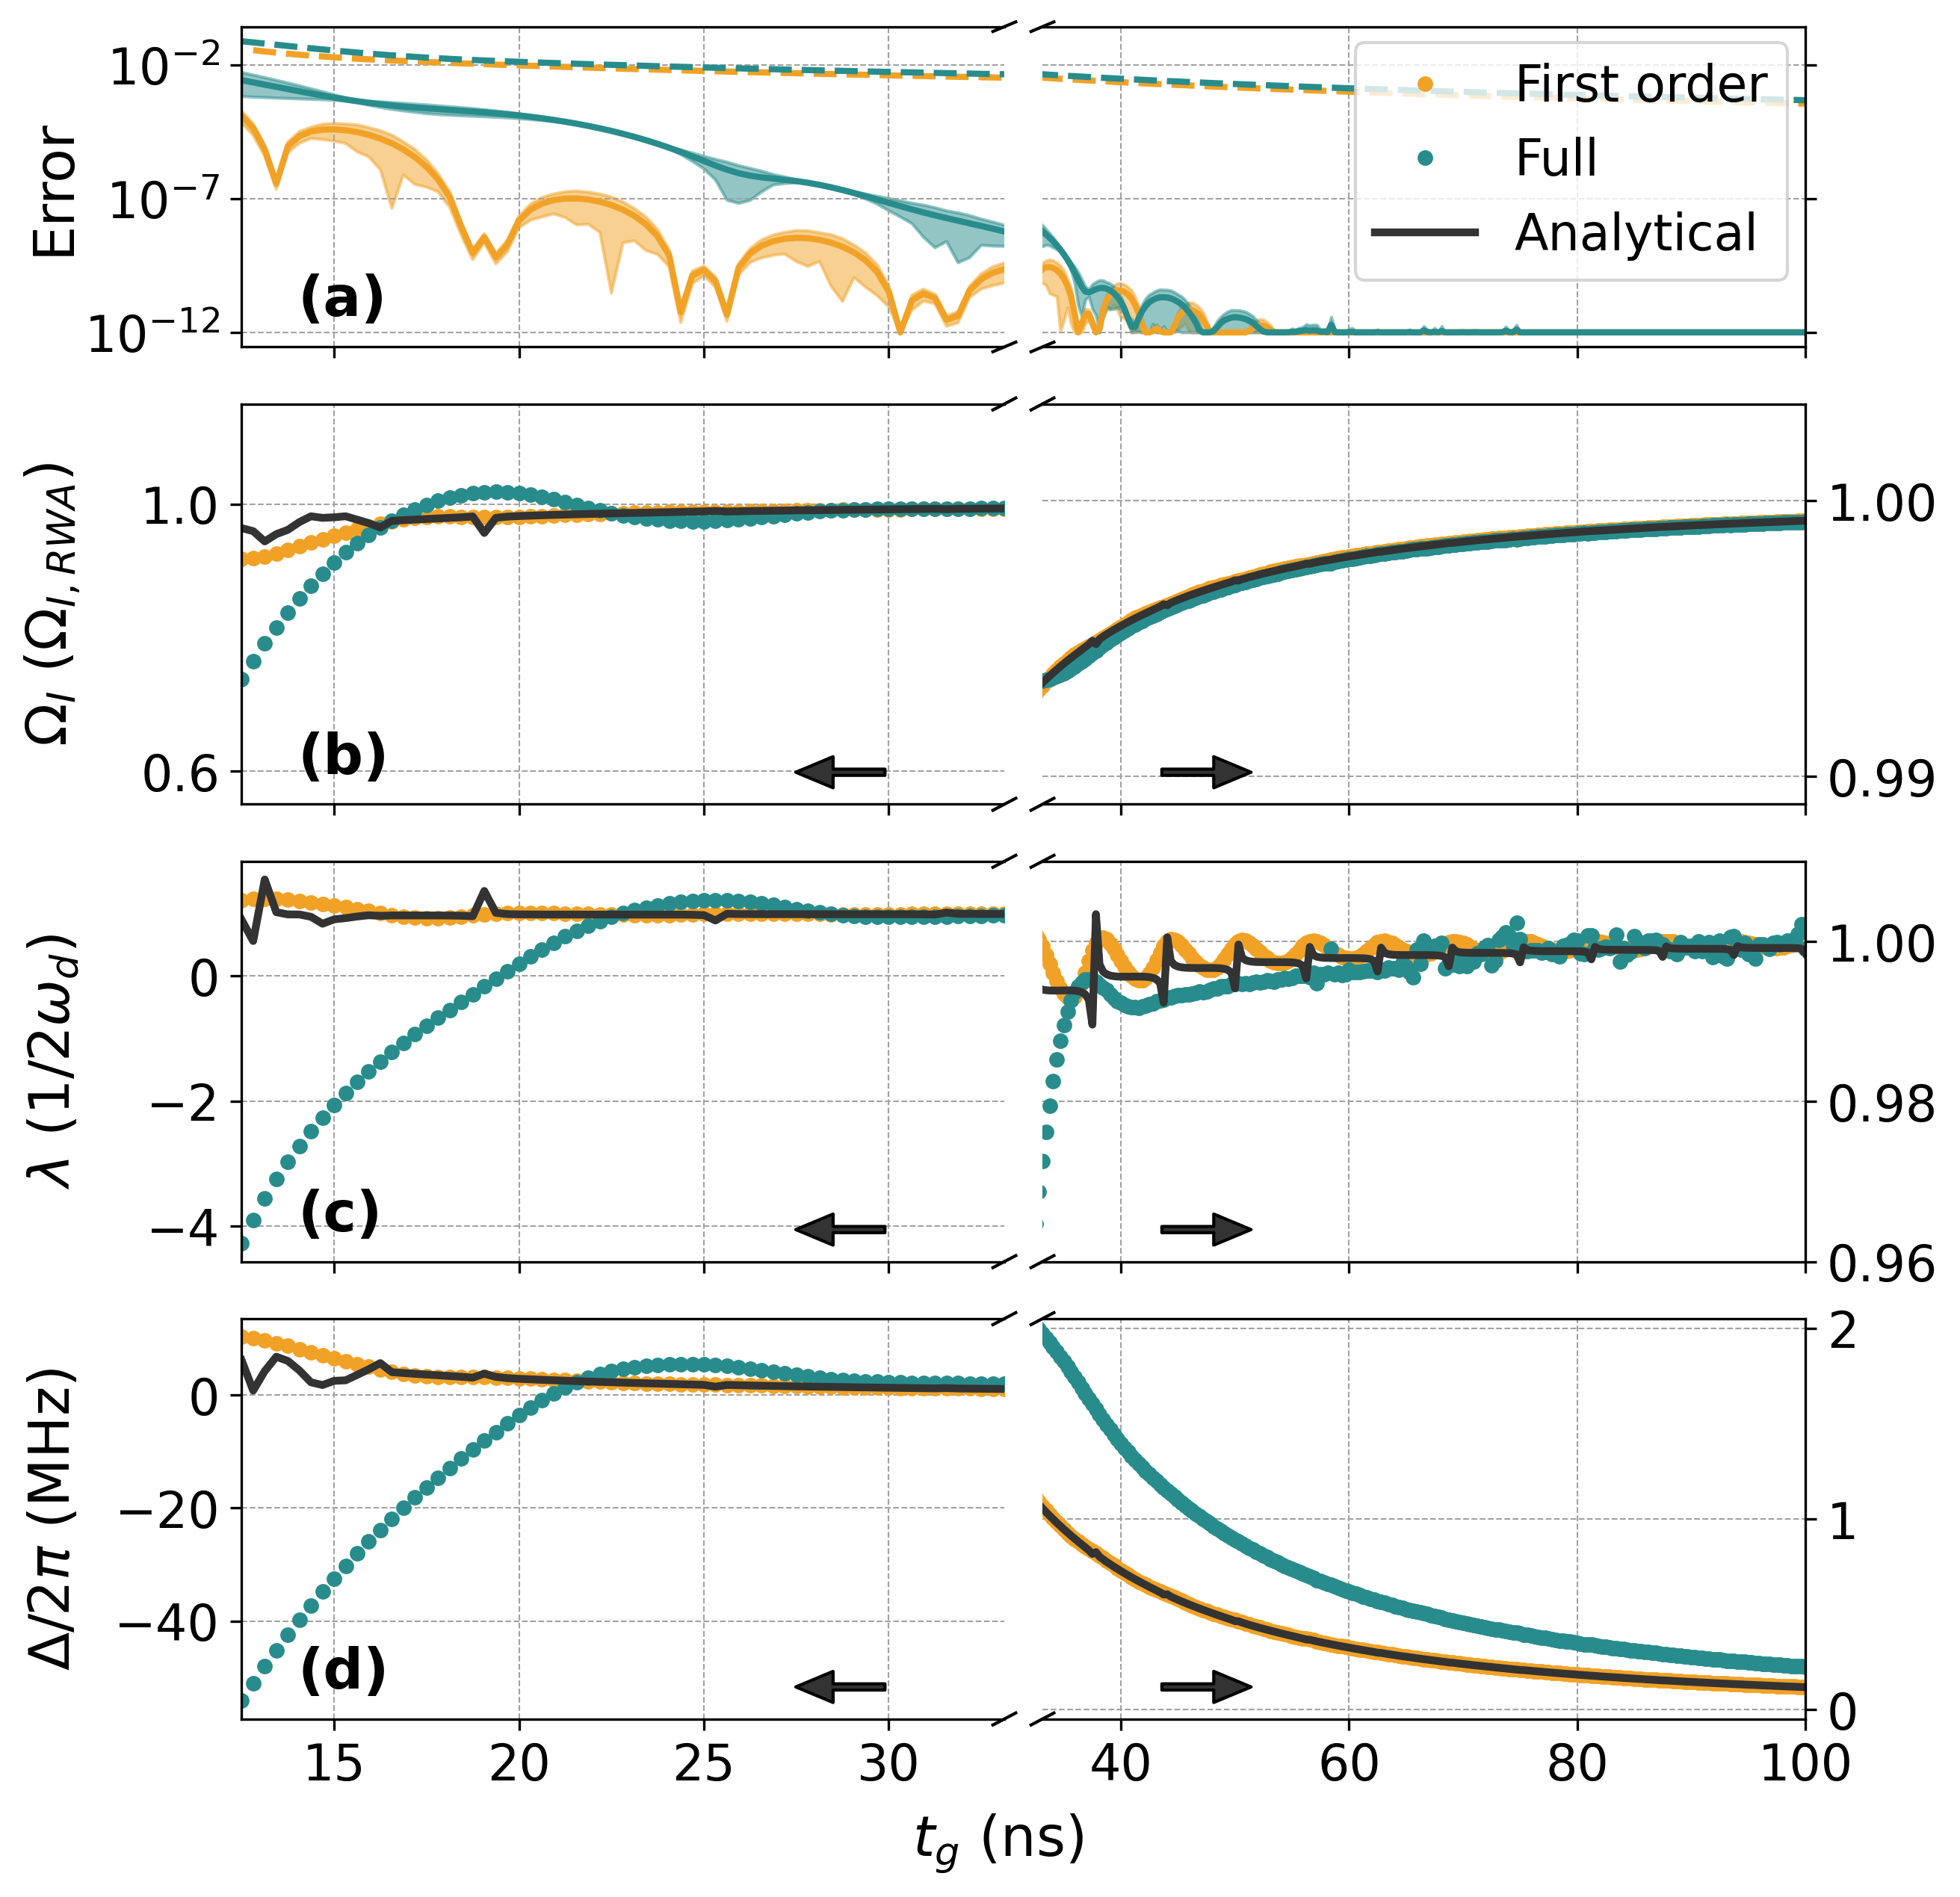

In [ ]:
fig,ax = plt.subplots(4, 2, figsize=(9,10), dpi=300, sharex=False, squeeze=True,
                      gridspec_kw={'height_ratios': [1, 1.25, 1.25, 1.25]})

ax[3,0].sharex(ax[2,0])
ax[2,0].sharex(ax[1,0])
ax[1,0].sharex(ax[0,0])
ax[3,1].sharex(ax[2,1])
ax[2,1].sharex(ax[1,1])
ax[1,1].sharex(ax[0,1])

# Set logscale ax1
ax[0,0].set_yscale("log")
ax[0,1].set_yscale("log")

# Set axis labels
# ax[-1,0].set_xlabel(r"$t_g$ (ns)")
# ax[-1,1].set_xlabel(r"$t_g$ (ns)")
fig.text(0.5, 0.064, r"$t_g$ (ns)", ha='center', fontsize=MEDIUM_SIZE)
ax[0,0].set_ylabel("Error")
ax[1,0].set_ylabel(r"$\Omega_I$ ($\Omega_{I,RWA}$)")
ax[2,0].set_ylabel(r"$\lambda$ ($1/2\omega_d$)")
ax[3,0].set_ylabel(r"$\Delta/2\pi$ (MHz)")

c1 = "#f1a226"
c2 = "#298c8c"

# Set lims & hide splines
for _ax in ax[:,0]:
    _ax.spines.right.set_visible(False)
    _ax.set_xlim(left=tgs[0]*1e9, right=tgs[cut_idx]*1e9)
for _ax in ax[:1,1]:
    _ax.spines.left.set_visible(False)
    _ax.set_xlim(left=tgs[cut_idx]*1e9, right=tgs[-1]*1e9)
    # _ax.get_yaxis().set_visible(False)
    _ax.yaxis.set_ticklabels([])
    _ax.yaxis.tick_right()
for _ax in ax[1:,1]:
    _ax.spines.left.set_visible(False)
    _ax.set_xlim(left=tgs[cut_idx]*1e9, right=tgs[-1]*1e9)
    _ax.yaxis.set_label_position("right")
    _ax.yaxis.tick_right()
    

# Plot data for row 1
for _ax in [ax[0,0], ax[0,1]]:
    _ax.plot(tgs*1e9, np.mean(errors, axis=1), linewidth=2, color=c1)
    _ax.plot(tgs*1e9, np.mean(errors_uncorrected, axis=1), linewidth=2, color=c1, linestyle="--")
    _ax.fill_between(tgs*1e9, np.min(errors, axis=1), np.max(errors, axis=1), color=c1, alpha=0.5)
    _ax.plot(tgs*1e9, np.mean(errors_full, axis=1), linewidth=2, color=c2)
    _ax.plot(tgs*1e9, np.mean(errors_uncorrected_full, axis=1), linewidth=2, color=c2, linestyle="--")
    _ax.fill_between(tgs*1e9, np.min(errors_full, axis=1), np.max(errors_full, axis=1), color=c2, alpha=0.5)
    _ax.set_yticks([1e-12, 1e-7, 1e-2])

# Plot data for row 2
for _ax in [ax[1,0], ax[1,1]]:
    _ax.plot(tgs*1e9, results_V0_numerical, linestyle="", marker=".", markersize=8, color=c1, label="First order")
    _ax.plot(tgs*1e9, results_V0_full, linestyle="", marker=".", markersize=8, color=c2, label="Full")
    _ax.plot(tgs*1e9, results_V0_theory, linewidth=2.5, color="#333", label="Analytical")

# Plot data for row 3
for _ax in [ax[2,0], ax[2,1]]:
    _ax.plot(tgs*1e9, results_ppp_numerical*tgs/np.pi * 2*wd_numerical, linestyle="", marker=".", markersize=8, color=c1)
    _ax.plot(tgs*1e9, results_ppp_full*tgs/np.pi * 2*wd_full, linestyle="", marker=".", markersize=8, color=c2)
    _ax.plot(tgs*1e9, results_ppp_theory * 2*wd_theory, linewidth=2.5, color="#333")

# Plot data for row 4
for _ax in [ax[3,0], ax[3,1]]:
    _ax.plot(tgs*1e9, results_delta_numerical, linestyle="", marker=".", markersize=8, color=c1)
    _ax.plot(tgs*1e9, results_delta_full, linestyle="", marker=".", markersize=8, color=c2)
    _ax.plot(tgs*1e9, results_delta_theory*1e-6/2/np.pi, linewidth=2.5, color="#333")

# Set more limits and ticks
f = 0.05
# Row 2
ax[1,1].set_ylim(bottom=0.99-0.02*f, top=1.0025+0.02*f)
ax[1,0].set_ylim(bottom=0.6-1*f, top=1.1+1*f)
ax[1,1].set_yticks([0.99,1])
ax[1,0].set_yticks([0.6,1])
# Row 3
ax[2,1].set_ylim(bottom=0.96, top=1.01)
ax[2,1].set_yticks([0.96,0.98,1])
# Row 4
ax[3,1].set_ylim(bottom=-0.05, top=2.05)
ax[3,1].set_yticks([0,1,2])

# Remove labels on first two rows
ax[0,0].set_xticklabels([])
ax[0,1].set_xticklabels([])
ax[1,0].set_xticklabels([])
ax[1,1].set_xticklabels([])
ax[2,0].set_xticklabels([])
ax[2,1].set_xticklabels([])

# Add legend
leg = ax[1,1].legend(loc=[0.41,1.16], frameon=False)
leg.legend_handles[0].set_markersize(11)
leg.legend_handles[1].set_markersize(11)

# Add cut lines in axis
d = 0.015

# Left axes
for _ax in ax[:,0]:
    kwargs = dict(transform=_ax.transAxes, color='k', clip_on=False, linewidth=1)
    _ax.plot((1-d, 1+d), (-d, +d), **kwargs)
    _ax.plot((1-d, 1+d), (1-d, 1+d), **kwargs)
# Right axes
for _ax in ax[:,1]:
    kwargs = dict(transform=_ax.transAxes, color='k', clip_on=False, linewidth=1)
    _ax.plot((-d, +d), (1-d, 1+d), **kwargs)
    _ax.plot((-d, +d), (-d, +d), **kwargs)


## Annotate (a), (b), (c), (d)
ax[0,0].annotate(text="(a)", 
                 xy=(0,0), 
                 xytext=(18,10), 
                 xycoords='axes points', 
                 fontsize=18,
                 weight="bold")
ax[1,0].annotate(text="(b)", 
                 xy=(0,0), 
                 xytext=(18,10), 
                 xycoords='axes points', 
                 fontsize=18,
                 weight="bold")
ax[2,0].annotate(text="(c)", 
                 xy=(0,0), 
                 xytext=(18,10), 
                 xycoords='axes points', 
                 fontsize=18,
                 weight="bold")
ax[3,0].annotate(text="(d)", 
                 xy=(0,0), 
                 xytext=(18,10), 
                 xycoords='axes points', 
                 fontsize=18,
                 weight="bold")

# Add arrows
for _ax in ax[1:,0]:
    _ax.annotate('', xy=(0.72,0.08), xycoords='axes fraction',
                 xytext=(0.85,0.08), textcoords='axes fraction',
                 arrowprops=dict(facecolor='#333', shrink=0.05, 
                                 width=2, headwidth=10))
for _ax in ax[1:,1]:
    _ax.annotate('', xy=(0.28,0.08), xycoords='axes fraction',
                 xytext=(0.15,0.08), textcoords='axes fraction',
                 arrowprops=dict(facecolor='#333', shrink=0.05, 
                                 width=2, headwidth=10))

for _ax in ax[:,0]:
    _ax.yaxis.set_label_coords(-0.21, 0.5)

# Adjust subplot spacing
fig.subplots_adjust(wspace=0.05, hspace=0.15)
fig.savefig("figure3.png", dpi=300)

## Figure 5 and figure appendix C

In [130]:
tgs = figure_data[4]["x1"]
ECs = figure_data[4]["x2"]
results_errors = figure_data[4]["y1"]
results_param1 = figure_data[4]["y2"]
results_param2 = figure_data[4]["y3"]
results_leakage = figure_data[4]["y5"]
results_uncorrected_errors = figure_data[4]["y6"] * 2/3
EJ = 5
EL = 1

results_w01 = np.zeros(len(ECs))
results_w02 = np.zeros(len(ECs))
results_w03 = np.zeros(len(ECs))
results_eta03 = np.zeros(len(ECs))
results_eta12 = np.zeros(len(ECs))
results_eta23 = np.zeros(len(ECs))

# Calculate fluxonium parameters
for i,EC in enumerate(ECs):
    fluxonium = scq.Fluxonium(EJ=EJ, 
                              EC=EC, 
                              EL=EL, 
                              flux=0.5, 
                              cutoff=30, 
                              truncated_dim=30)
    E = fluxonium.eigenvals()

    w01 = (E[1]-E[0])*1e9*2*np.pi
    w02 = (E[2]-E[0])*1e9*2*np.pi
    w03 = (E[3]-E[0])*1e9*2*np.pi
    alpha2 = w02-2*w01
    alpha3 = w03-3*w01

    eta12 = np.abs(fluxonium.matrixelement_table("n_operator")[1,2])/np.abs(fluxonium.matrixelement_table("n_operator")[0,1])
    eta03 = np.abs(fluxonium.matrixelement_table("n_operator")[0,3])/np.abs(fluxonium.matrixelement_table("n_operator")[0,1])
    eta23 = np.abs(fluxonium.matrixelement_table("n_operator")[2,3])/np.abs(fluxonium.matrixelement_table("n_operator")[0,1])

    results_w01[i] = w01 
    results_w02[i] = w02
    results_w03[i] = w03 

    results_eta03[i] = eta03
    results_eta12[i] = eta12
    results_eta23[i] = eta23

### Figure 5

In [131]:
results_errors = np.clip(results_errors, 1e-12, 1)

In [132]:
# Define interpolation objects for axis labels
xx_interp = interp1d(tgs*1e9, np.arange(len(tgs)))
yy_interp = interp1d(ECs, len(ECs) - np.arange(len(ECs)))

# Define values for axis ticks
x_vals = np.array([tgs[0]*1e9, 40, 70, tgs[-1]*1e9])
y_vals = np.array([0.5, 1, 1.5])

In [ ]:
idx_x = len(tgs)//5, (4*len(tgs))//5
idx_y = len(ECs)//5, (4*len(ECs))//5
idxs_x = [idx_x[0], idx_x[0], idx_x[1], idx_x[1]]
idxs_y = [idx_y[0], idx_y[1], idx_y[0], idx_y[1]]

N = 1000
deltas1 = np.zeros((4, N))
deltas2 = np.zeros((4, N))
for i in range(4):
    alpha2 = results_w02[idxs_y[i]]-2*results_w01[idxs_y[i]]
    alpha3 = results_w03[idxs_y[i]]-3*results_w01[idxs_y[i]]
    omega_unit = -1/2*(
        results_eta03[idxs_y[i]]**2/alpha3 -
        results_eta12[idxs_y[i]]**2/alpha2
    )
    eps = results_param1[idxs_x[i],idxs_y[i]]
    omega_delta = results_param2[idxs_x[i],idxs_y[i]]
    tg = tgs[idxs_x[i]]
    pulse_envelope = CosinePulseEnvelope(tg=tg)
    ts = np.linspace(0,tg,N)

    # Calculate \Delta
    deltas1[i,:] = omega_unit*omega_delta*eps**2*pulse_envelope.V0**2 * np.square(
        pulse_envelope.envelope(ts)
    )

    # Calculate \Theta(t)
    delta = lambda t: omega_unit * eps**2 * omega_delta * pulse_envelope.V0**2 / t * (
        pulse_envelope.envelope_square_int(t)
    )
    
    deltas2[i,:] = np.nan_to_num(delta(ts), nan=0)

In [ ]:
marker_list = ["^", "<", "v", ">"]
color_list = ["#75490F", "#A3742D", "#CDA26A", "#F2D39A"]
handles = []
for i in range(4):
    handles.append(mpl.lines.Line2D([], [], color=color_list[i], marker=marker_list[i], markersize=10, linestyle='None', label=''))

In [ ]:
fig,ax = plt.subplots(2, 2, figsize=(9,7.3), dpi=300) # row, column

# Plot error
ax[0,0] = sns.heatmap(data=np.flip(results_uncorrected_errors.T, axis=0), 
                    xticklabels=tgs*1e9, 
                    yticklabels=np.round(np.flip(ECs),2), 
                    cmap="Blues_r", 
                    cbar_kws={"label": "Uncorrected error", 
                              "location": "top",
                              "ticks": [1e-4,1e-2,1e0]}, 
                    ax=ax[0,0],
                    norm=LogNorm(vmin=1e-4,vmax=1),
                    cbar=True)

ax[0,0].set_xticks(ticks=[0.5+i for i in xx_interp(x_vals)],
                   labels=[""]*len(x_vals),
                   rotation=0)
ax[0,0].set_yticks(ticks=[-0.5+i for i in yy_interp(y_vals)],
                   labels=np.round(y_vals, 1))
ax[0,0].set(xlabel=r"", ylabel=r"$E_C/h$ (GHz)")

# Plot error
ax[1,0] = sns.heatmap(data=np.flip(results_errors.T, axis=0), 
                    xticklabels=tgs*1e9, 
                    yticklabels=np.round(np.flip(ECs),2), 
                    cmap="Blues_r", 
                    cbar_kws={"label": "Optimized error", 
                              "location": "top",
                              "ticks": [1e-12,1e-8,1e-4,1e0]}, 
                    ax=ax[1,0],
                    norm=LogNorm(vmin=1e-12,vmax=1),
                    cbar=True)

ax[1,0].set_xticks(ticks=[0.5+i for i in xx_interp(x_vals)],
                   labels=np.round(x_vals).astype(int),
                   rotation=0)
ax[1,0].set_yticks(ticks=[-0.5+i for i in yy_interp(y_vals)],
                   labels=np.round(y_vals, 1))
ax[1,0].set(xlabel=r"$t_g$ (ns)", ylabel=r"$E_C/h$ (GHz)")
for i in range(4):
    ax[1,0].plot(xx_interp(tgs[idxs_x][i]*1e9)+0.5, yy_interp(ECs[idxs_y][i])-0.5, marker=marker_list[i], markersize=10, color=color_list[i])

# Plot leakage
ax[0,1] = sns.heatmap(data=np.flip(results_leakage.T, axis=0), 
                      xticklabels=tgs*1e9, 
                      yticklabels=np.round(np.flip(ECs),2), 
                      cmap="Blues_r", 
                      cbar_kws={"label": "Leakage", "location": "top"}, 
                      ax=ax[0,1],
                      norm=LogNorm(),
                      cbar=True)

ax[0,1].set_xticks(ticks=[0.5+i for i in xx_interp(x_vals)],
                   labels=[""]*len(x_vals),
                   rotation=0)
ax[0,1].set_yticks(ticks=[-0.5+i for i in yy_interp(y_vals)],
                   labels=[""]*len(y_vals))
ax[0,1].set(xlabel=r"", ylabel=r"")

# Plot traces
for i in range(4):
    ax[1,1].plot(np.linspace(0,1,N), deltas1[i,:]*1e-6/2/np.pi, linewidth=2, color=color_list[i], linestyle=(0, (5, 8)), zorder=0)
    ax[1,1].plot(np.linspace(0,1,N), deltas2[i,:]*1e-6/2/np.pi, linewidth=2, color=color_list[i], label=i, zorder=1)

ax[1,1].set_xlabel(r"$t$ ($t_g$)")
ax[1,1].set_ylabel(r"$\Delta(t)/2\pi$, $\Delta^\prime(t)/2\pi$ (MHz)")
ax[1,1].set_yticks([0,2,4,6])

# Annotate (a) and (b)
ax[0,0].annotate(text="(a)", 
               xy=(0,0), 
               xytext=(5,138), 
               xycoords='axes points', 
               color="#fff",
               fontsize=18,
               weight="bold",
               path_effects=[pe.withStroke(linewidth=2, foreground="#333")])
ax[1,0].annotate(text="(b)", 
               xy=(0,0), 
               xytext=(5,138), 
               xycoords='axes points', 
               color="#fff",
               fontsize=18,
               weight="bold",
               path_effects=[pe.withStroke(linewidth=2, foreground="#333")])
ax[0,1].annotate(text="(c)", 
               xy=(0,0), 
               xytext=(5,138), 
               xycoords='axes points', 
               color="#fff",
               fontsize=18,
               weight="bold",
               path_effects=[pe.withStroke(linewidth=2, foreground="#333")])
ax[1,1].annotate(text="(d)", 
               xy=(0,0), 
               xytext=(5,177), 
               xycoords='axes points', 
               color="#333",
               fontsize=18,
               weight="bold")

plt.subplots_adjust(wspace=0, hspace=0)
fig.tight_layout()
fig.savefig("figure5.png", dpi=300)

### Figure 5 appendix

In [ ]:
# Init figure
fig,ax = plt.subplots(1, 4, figsize=(18,4), dpi=300) # row, column

color_list = ["#f1a226", "#298c8c", "#8C3C29"]

# Plot energy levels
ax[0].plot(ECs, results_w01*1e-9/2/np.pi, linewidth=3, color=color_list[0], label=r"$\omega_1$")
ax[0].plot(ECs, (results_w02-2*results_w01)*1e-9/2/np.pi, linewidth=3, color=color_list[1], label=r"$\omega_2-2\omega_1$")
ax[0].plot(ECs, (results_w03-3*results_w01)*1e-9/2/np.pi, linewidth=3, color=color_list[2], label=r"$\omega_3-3\omega_1$")
ax[0].set_yscale("log")

ax[0].set_xticks(y_vals)
ax[0].set_xlabel(r"$E_C/h$ (GHz)")
ax[0].set_ylabel(r"$\omega/2\pi$ (GHz)")
ax[0].legend(loc=[0.02,0.42], frameon=False)

# Plot charge matrix elements
ax[1].plot(ECs, results_eta03, linewidth=3, color=color_list[0], label=r"$ij=03$")
ax[1].plot(ECs, results_eta12, linewidth=3, color=color_list[1], label=r"$ij=12$")
ax[1].plot(ECs, results_eta23, linewidth=3, color=color_list[2], label=r"$ij=23$")
ax[1].legend(loc=[0.55,0.58], frameon=False)

ax[1].set_xticks(y_vals)
ax[1].set_xlabel(r"$E_C/h$ (GHz)")
ax[1].set_ylabel(r"$\eta_{ij}$")

vmin = np.min(np.concatenate((results_param1, results_param2)))
vmax = np.max(np.concatenate((results_param1, results_param2)))

# Plot phase ramping parameters 
ax[2] = sns.heatmap(data=np.flip(results_param2.T, axis=0), 
                    xticklabels=tgs*1e9, 
                    yticklabels=np.round(np.flip(ECs),2), 
                    cmap="Blues_r", 
                    cbar_kws={"label": r"$\Omega_\Delta$", "location": "top"}, 
                    ax=ax[2],
                    cbar=True,
                    vmin=vmin,
                    vmax=vmax)

ax[2].set_xticks(ticks=[0.5+i for i in xx_interp(x_vals)],
                 labels=np.round(x_vals).astype(int),
                 rotation=0)
ax[2].set_yticks(ticks=[-0.5+i for i in yy_interp(y_vals)],
                 labels=np.round(y_vals, 1))
ax[2].set(xlabel=r"$t_g$ (ns)", ylabel=r"$E_C/h$ (GHz)")

# Plot relative drive strength
ax[3] = sns.heatmap(data=np.flip(results_param1.T, axis=0), 
                    xticklabels=tgs*1e9, 
                    yticklabels=np.round(np.flip(ECs),2), 
                    cmap="Blues_r", 
                    cbar_kws={"label": r"$\epsilon$", "location": "top"}, 
                    ax=ax[3],
                    cbar=True,
                    vmin=vmin,
                    vmax=vmax)

ax[3].set_xticks(ticks=[0.5+i for i in xx_interp(x_vals)],
                 labels=np.round(x_vals).astype(int),
                 rotation=0)
ax[3].set_yticks(ticks=[-0.5+i for i in yy_interp(y_vals)],
                 labels=[""]*len(y_vals))
ax[3].set_xlabel(r"$t_g$ (ns)")

# Annotate (a), (b), (c), (d)
ax[0].annotate(text="(a)", 
               xy=(0,0), 
               xytext=(2,206), 
               xycoords='axes points', 
               fontsize=18,
               weight="bold")
ax[1].annotate(text="(b)", 
               xy=(0,0), 
               xytext=(2,206), 
               xycoords='axes points', 
               fontsize=18,
               weight="bold")
ax[2].annotate(text="(c)", 
               xy=(0,0), 
               xytext=(216,138), 
               xycoords='axes points', 
               fontsize=18,
               weight="bold")
ax[3].annotate(text="(d)", 
               xy=(0,0), 
               xytext=(216,138), 
               xycoords='axes points', 
               fontsize=18,
               weight="bold")

plt.subplots_adjust(wspace=0, hspace=0)
fig.tight_layout()

fig.savefig("figure5-appendix.png", dpi=300)

## Figure 6

In [7]:
w01 = 2*np.pi*80e6

errors_pi_40ns  = np.clip(2/3*figure_data[5]["y1"], 1e-12, 1)
errors_pi2_40ns = np.clip(2/3*figure_data[5]["y2"], 1e-12, 1)
errors_pi_100ns  = np.clip(2/3*figure_data[5]["y3"], 1e-12, 1)
errors_pi2_100ns = np.clip(2/3*figure_data[5]["y4"], 1e-12, 1)

V0_pi_40ns  = figure_data[5]["y5"]
V0_pi2_40ns = figure_data[5]["y6"]
V0_pi_100ns  = figure_data[5]["y7"]
V0_pi2_100ns = figure_data[5]["y8"]

results_ppp_pi2 = figure_data[5]["y11"]*2*w01
results_ppp_pi  = figure_data[5]["y12"]*2*w01
results_detuning_pi2 = figure_data[5]["y13"]*1e-6/2/np.pi
results_detuning_pi  = figure_data[5]["y14"]*1e-6/2/np.pi

tgs = figure_data[5]["x1"]
ppps = figure_data[5]["x2"]
detunings = figure_data[5]["x3"]*1e-6/2/np.pi
betas = figure_data[5]["x4"]

In [8]:
# Parse theory params
# This is a little bit hacky but pls allow me
x_vals_theory = [np.array([]) for _ in range(8)]
y_vals_theory = [np.array([]) for _ in range(8)]

iter_obj = zip(
    [results_ppp_pi2[0,:], results_ppp_pi[0,:], results_ppp_pi2[1,:], results_ppp_pi[1,:]],
    [results_detuning_pi2[0,:], results_detuning_pi[0,:], results_detuning_pi2[1,:], results_detuning_pi[1,:]]
)

for i,tg in enumerate(tgs):
    for k,(results_ppp,results_detuning) in enumerate(iter_obj):
        idx = i*2 + k

        for j in range(len(betas)):
            if (ppps[0]<=results_ppp[j]<=ppps[-1]) and \
                (detunings[0]<=results_detuning[j]<=detunings[-1]):
                x_vals_theory[idx] = np.append(x_vals_theory[idx], results_ppp[j])
                y_vals_theory[idx] = np.append(y_vals_theory[idx], results_detuning[j])

idxs = [np.argsort(x) for x in x_vals_theory]
x_vals_theory = [x[idxs[i]] for i,x in enumerate(x_vals_theory)]
y_vals_theory = [x[idxs[i]] for i,x in enumerate(y_vals_theory)]

In [9]:
# Define interpolation objects for axis labels
xx_interp = interp1d(ppps, np.arange(len(ppps)))
yy_interp = interp1d(detunings, len(detunings) - np.arange(len(detunings)))

# Define values for axis ticks
x_vals = np.array([-0.5, 0, 0.5])
y_vals = np.array([-0.4, 0, 0.4])

# Calc/set min/max
min1 = min([np.min(errors_pi2_40ns), np.min(errors_pi_40ns), np.min(errors_pi2_100ns), np.min(errors_pi_100ns),])
min1 = 1e-9
max1 = 1

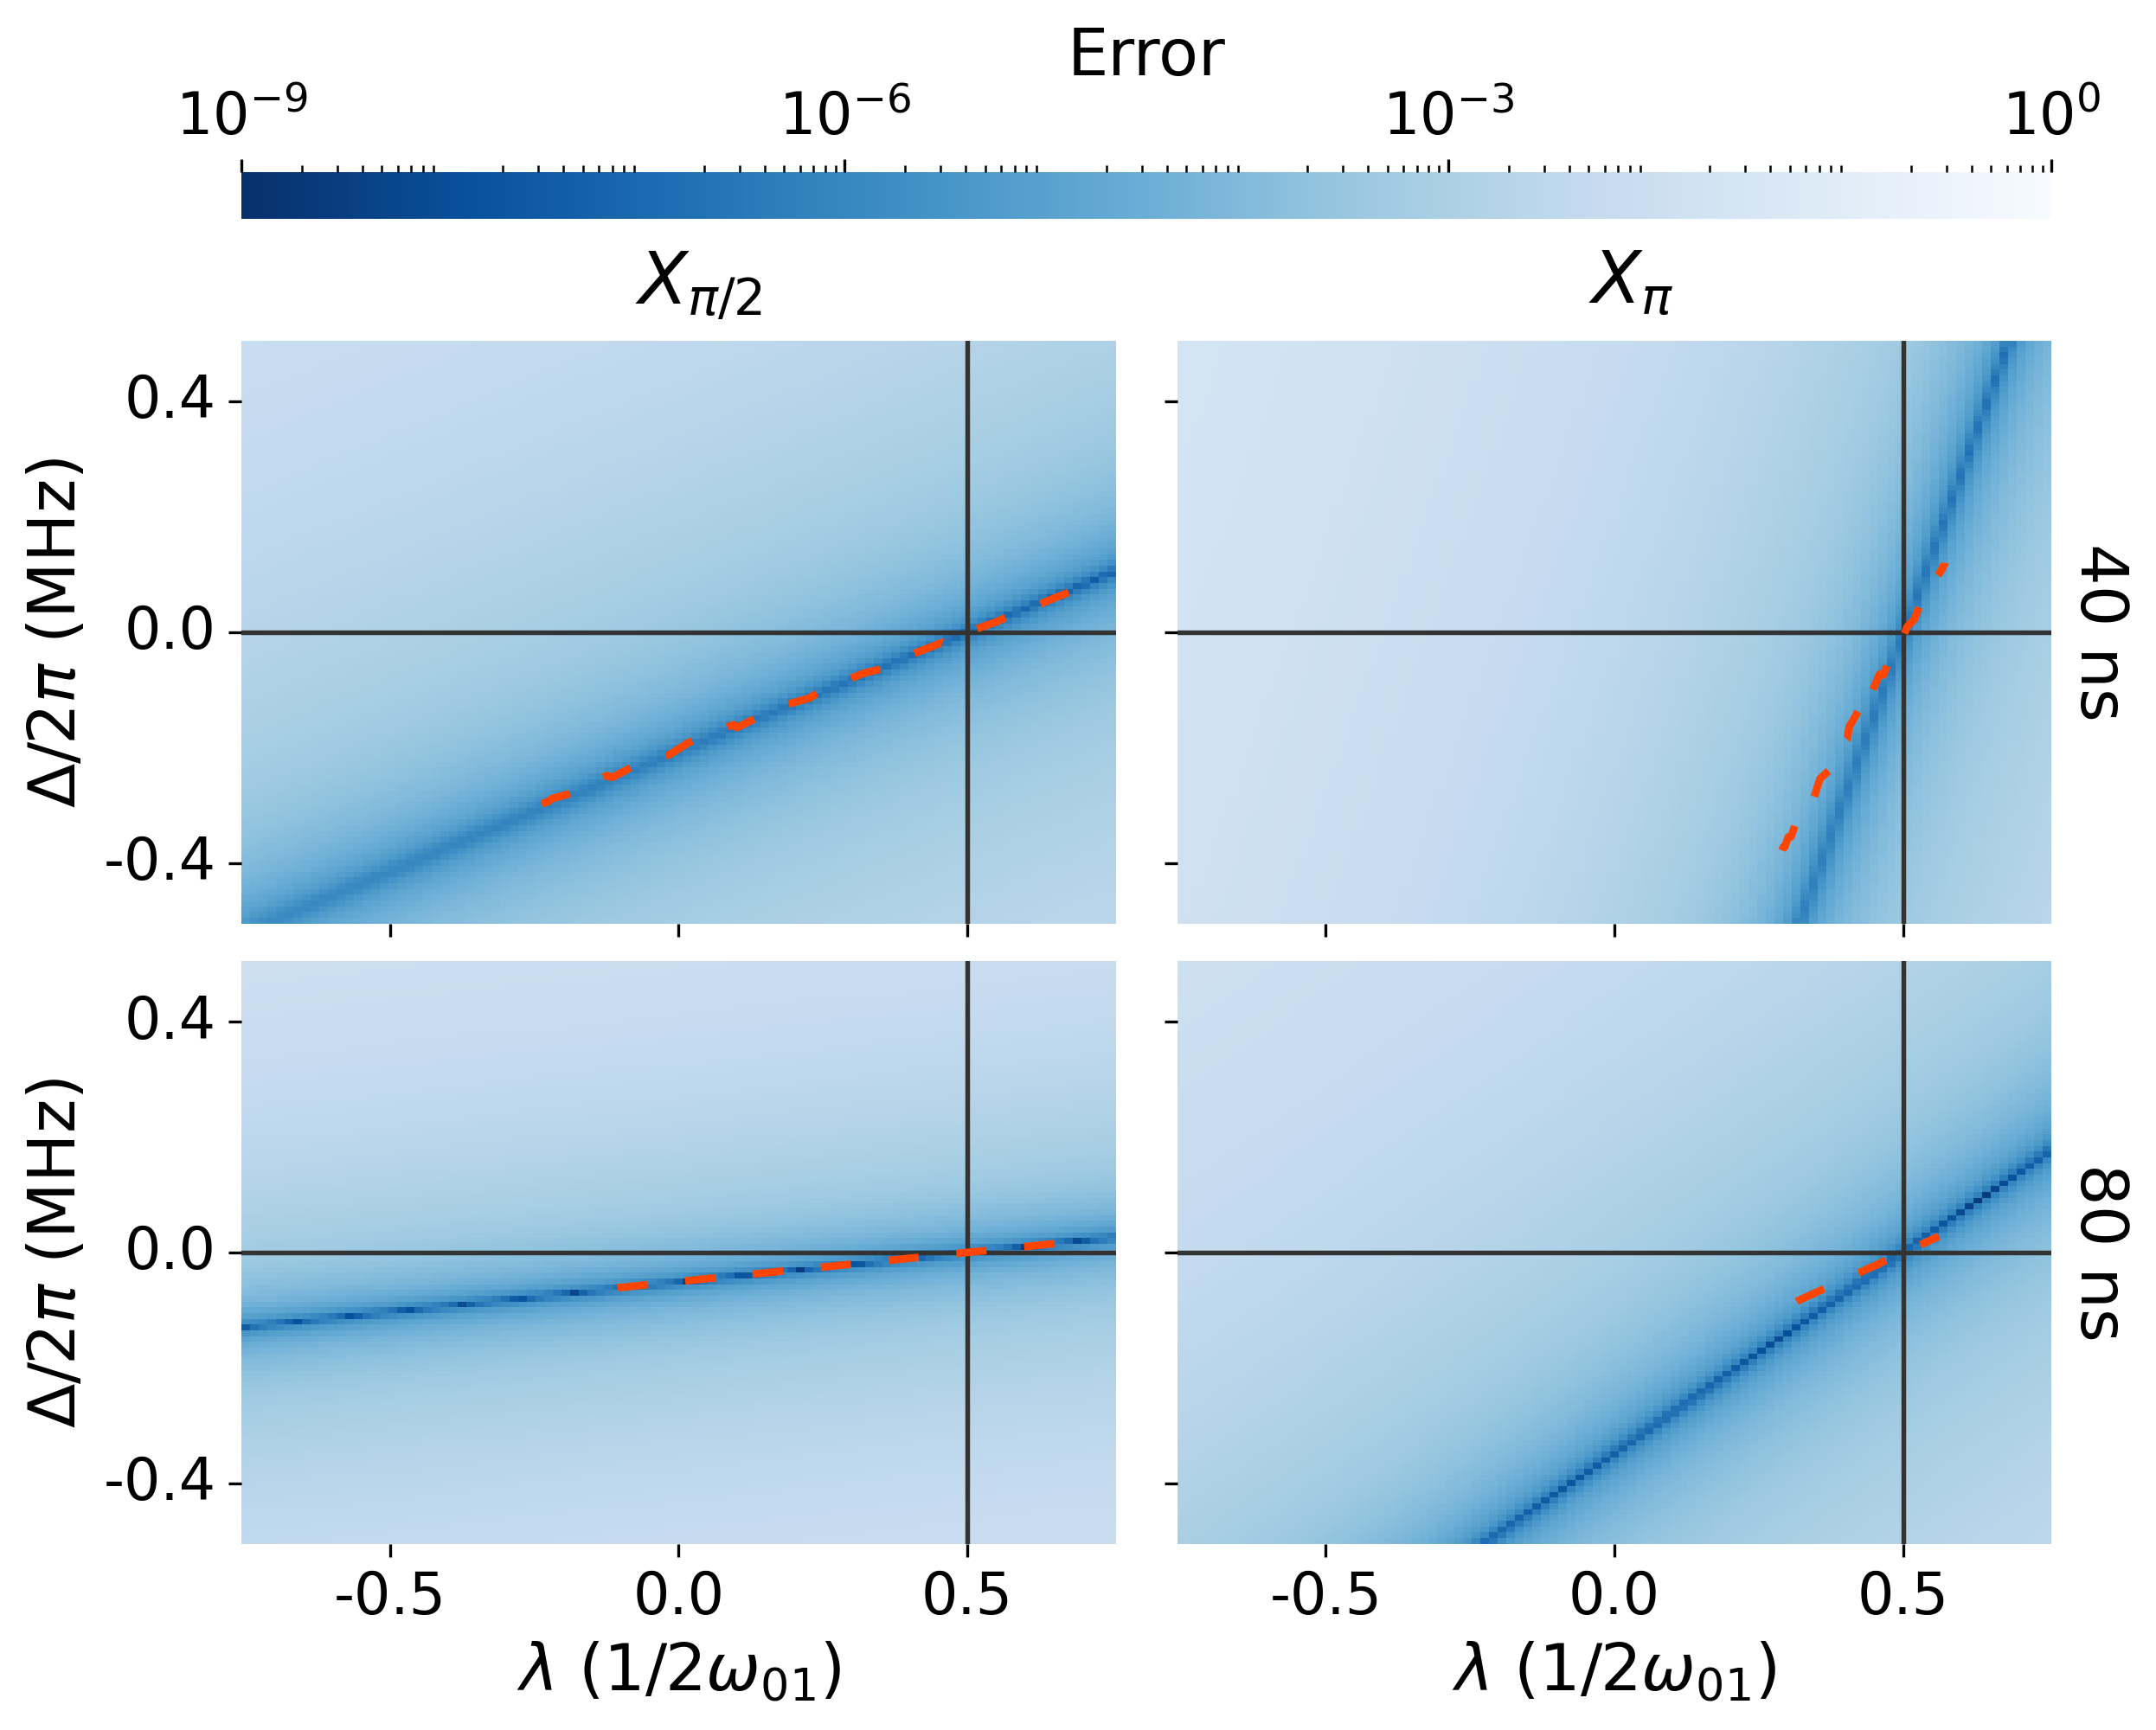

In [10]:
fig = plt.figure(figsize=(9,7), dpi=300)
gs = plt.GridSpec(4,2, figure=fig, height_ratios=[0.08,0.08,1,1], wspace=0.07, hspace=0.12)

# Actual axis with data
ax1 = fig.add_subplot(gs[2,0])
ax2 = fig.add_subplot(gs[2,1])
ax3 = fig.add_subplot(gs[3,0])
ax4 = fig.add_subplot(gs[3,1])
# Axis for heatmap
ax5 = fig.add_subplot(gs[0,:])
# Axis for text
ax6 = fig.add_subplot(gs[1,0])
ax7 = fig.add_subplot(gs[1,1])

linecolor = colors["red"]
cmap = "Blues_r"

# label on top
ax6.set_axis_off()
ax7.set_axis_off()
ax6.text(0.45, 0, r"$X_{\pi/2}$", fontsize=20)
ax7.text(0.47, 0, r"$X_{\pi}$", fontsize=20)
# labels on right
for _ax,label in zip([ax2,ax4], ["40 ns", "80 ns"]):
    __ax = _ax.twinx()
    __ax.grid(False)
    __ax.set_yticks([])
    __ax.set_xticks([])
    __ax.spines['top'].set_visible(False)
    __ax.spines['right'].set_visible(False)
    __ax.spines['bottom'].set_visible(False)
    __ax.spines['left'].set_visible(False)
    __ax.set_ylabel(label, rotation=270)
    __ax.yaxis.set_label_coords(1.09, 0.5)

## Plot figure 1a
ax1 = sns.heatmap(data=np.flip(errors_pi2_40ns.T, axis=0), 
                  xticklabels=ppps, 
                  yticklabels=np.flip(detunings), 
                  cmap=cmap, 
                  ax=ax1,
                  norm=LogNorm(vmin=min1, vmax=max1),
                  cbar=False)

# Set axis ticks and labels
ax1.set_xticks(ticks=[0.5+i for i in xx_interp(x_vals)],
               labels=[""]*len(x_vals))
ax1.set_yticks(ticks=[-0.5+i for i in yy_interp(y_vals)],
               labels=np.round(y_vals,1))
ax1.set(xlabel=r"", ylabel=r"$\Delta/2\pi$ (MHz)")

## Plot figure 1b
ax2 = sns.heatmap(data=np.flip(errors_pi_40ns.T, axis=0), 
                  xticklabels=ppps, 
                  yticklabels=np.flip(detunings), 
                  cmap=cmap, 
                  ax=ax2, 
                  norm=LogNorm(vmin=min1, vmax=max1),
                  cbar=False)

# Set axis ticks and labels
ax2.set_xticks(ticks=[0.5+i for i in xx_interp(x_vals)],
               labels=[""]*len(x_vals))
ax2.set_yticks(ticks=[-0.5+i for i in yy_interp(y_vals)],
               labels=[""]*len(y_vals))
ax2.set(xlabel=r"", ylabel=r"")

## Plot figure 1c
ax3 = sns.heatmap(data=np.flip(errors_pi2_100ns.T, axis=0), 
                  xticklabels=ppps, 
                  yticklabels=np.flip(detunings), 
                  cmap=cmap, 
                  ax=ax3, 
                  norm=LogNorm(vmin=min1, vmax=max1),
                  cbar=False)

# Set axis ticks and labels
ax3.set_xticks(ticks=[0.5+i for i in xx_interp(x_vals)])
ax3.set_xticklabels(x_vals, rotation=0)
ax3.set_yticks(ticks=[-0.5+i for i in yy_interp(y_vals)],
               labels=np.round(y_vals,1))
ax3.set(xlabel=r"$\lambda$ ($1/2\omega_{01}$)", ylabel=r"$\Delta/2\pi$ (MHz)")

## Plot figure 1d
ax4 = sns.heatmap(data=np.flip(errors_pi_100ns.T, axis=0), 
                  xticklabels=ppps, 
                  yticklabels=np.flip(detunings), 
                  cmap=cmap, 
                  cbar_ax=ax5,
                  cbar_kws={"label": "Error",
                            "ticks":[1e-12, 1e-9, 1e-6, 1e-3, 1],
                            "orientation": "horizontal",
                            "location": "top"}, 
                  ax=ax4, 
                  norm=LogNorm(vmin=min1, 
                               vmax=max1))

# Set axis ticks and labels
ax4.set_xticks(ticks=[0.5+i for i in xx_interp(x_vals)])
ax4.set_xticklabels(x_vals, rotation=0)
ax4.set_yticks(ticks=[-0.5+i for i in yy_interp(y_vals)],
               labels=[""]*len(y_vals))
ax4.set(xlabel=r"$\lambda$ ($1/2\omega_{01}$)", ylabel=r"")

# Plot lines
for _ax in [ax1, ax2, ax3, ax4]:
    xx = np.linspace(ppps[0], ppps[-1], 101)
    _ax.axhline(yy_interp(0)-0.5, linestyle="-", color="#333", linewidth=1.3)
    _ax.axvline(xx_interp(0.5)+0.5, linestyle="-", color="#333", linewidth=1.3)

ax1.plot(xx_interp(x_vals_theory[0])+0.5, yy_interp(y_vals_theory[0])-0.5, linestyle=(0, (4, 5)), color=colors["red"], linewidth=2.1)
ax2.plot(xx_interp(x_vals_theory[1])+0.5, yy_interp(y_vals_theory[1])-0.5, linestyle=(0, (4, 5)), color=colors["red"], linewidth=2.1)
ax3.plot(xx_interp(x_vals_theory[2])+0.5, yy_interp(y_vals_theory[2])-0.5, linestyle=(0, (4, 5)), color=colors["red"], linewidth=2.1)
ax4.plot(xx_interp(x_vals_theory[3])+0.5, yy_interp(y_vals_theory[3])-0.5, linestyle=(0, (4, 5)), color=colors["red"], linewidth=2.1)

fig.savefig("figure6.png", dpi=300)

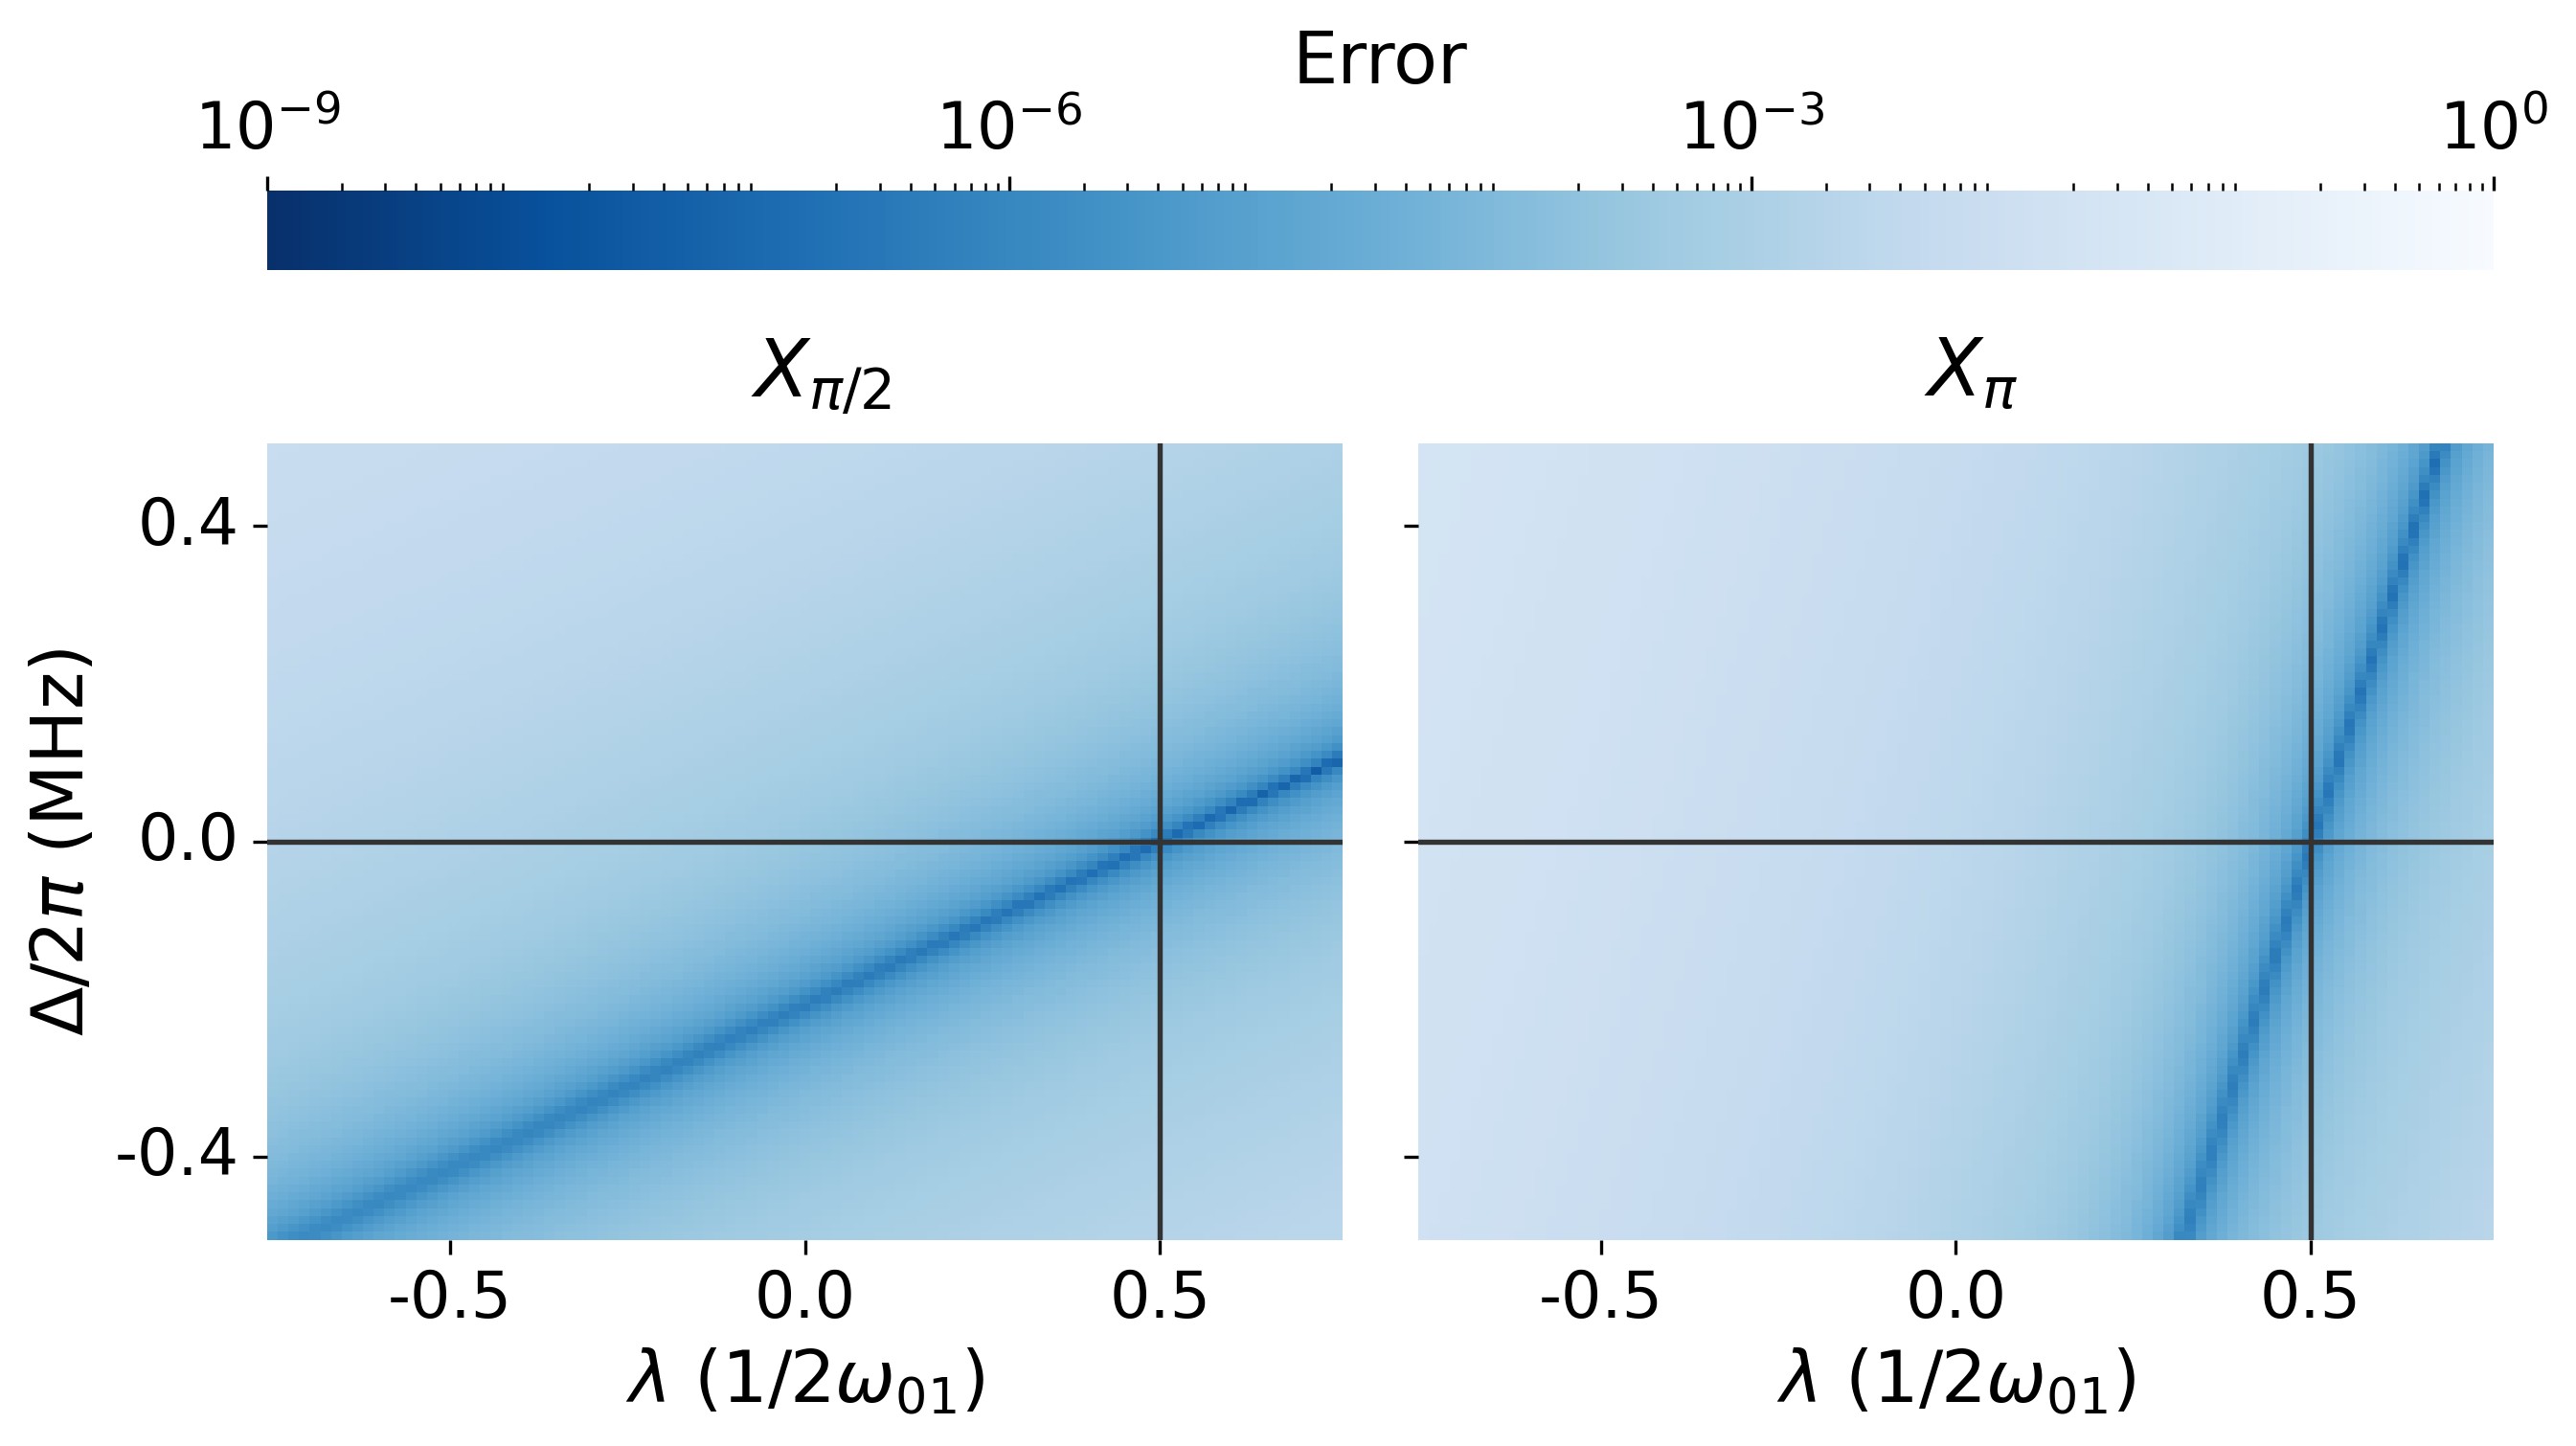

In [11]:
fig = plt.figure(figsize=(10,5.75), dpi=300)
gs = plt.GridSpec(3,2, figure=fig, height_ratios=[0.08,0.08,1], wspace=0.07, hspace=0.12)

# Actual axis with data
ax1 = fig.add_subplot(gs[2,0])
ax2 = fig.add_subplot(gs[2,1])
# Axis for heatmap
ax5 = fig.add_subplot(gs[0,:])
# Axis for text
ax6 = fig.add_subplot(gs[1,0])
ax7 = fig.add_subplot(gs[1,1])

linecolor = colors["red"]
cmap = "Blues_r"

# label on top
ax6.set_axis_off()
ax7.set_axis_off()
ax6.text(0.45, 0, r"$X_{\pi/2}$", fontsize=20)
ax7.text(0.47, 0, r"$X_{\pi}$", fontsize=20)

## Plot figure 1a
ax1 = sns.heatmap(data=np.flip(errors_pi2_40ns.T, axis=0), 
                  xticklabels=ppps, 
                  yticklabels=np.flip(detunings), 
                  cmap=cmap, 
                  ax=ax1,
                  norm=LogNorm(vmin=min1, vmax=max1),
                  cbar=False)

# Set axis ticks and labels
ax1.set_xticks(ticks=[0.5+i for i in xx_interp(x_vals)],
               labels=x_vals, rotation=0)
ax1.set_yticks(ticks=[-0.5+i for i in yy_interp(y_vals)],
               labels=np.round(y_vals,1))
ax1.set(xlabel=r"$\lambda$ ($1/2\omega_{01}$)", ylabel=r"$\Delta/2\pi$ (MHz)")

## Plot figure 1b
ax2 = sns.heatmap(data=np.flip(errors_pi_40ns.T, axis=0), 
                  xticklabels=ppps, 
                  yticklabels=np.flip(detunings), 
                  cmap=cmap, 
                  cbar_ax=ax5,
                  cbar_kws={"label": "Error",
                            "ticks":[1e-12, 1e-9, 1e-6, 1e-3, 1],
                            "orientation": "horizontal",
                            "location": "top"}, 
                  ax=ax2, 
                  norm=LogNorm(vmin=min1, 
                               vmax=max1))

# Set axis ticks and labels
ax2.set_xticks(ticks=[0.5+i for i in xx_interp(x_vals)],
               labels=x_vals, rotation=0)
ax2.set_yticks(ticks=[-0.5+i for i in yy_interp(y_vals)],
               labels=[""]*len(y_vals))
ax2.set(xlabel=r"$\lambda$ ($1/2\omega_{01}$)", ylabel=r"")

# Plot lines
for _ax in [ax1, ax2]:
    xx = np.linspace(ppps[0], ppps[-1], 101)
    _ax.axhline(yy_interp(0)-0.5, linestyle="-", color="#333", linewidth=1.3)
    _ax.axvline(xx_interp(0.5)+0.5, linestyle="-", color="#333", linewidth=1.3)

for _ax in [ax1, ax2]:
    pos = _ax.get_position()  # Get the current position of the axis
    new_pos = [pos.x0, pos.y0+0.1, pos.width, 0.8*pos.height]
    _ax.set_position(new_pos)
for _ax in [ax5, ax6, ax7]:
    pos = _ax.get_position()  # Get the current position of the axis
    new_pos = [pos.x0, pos.y0-0.02, pos.width, pos.height]
    _ax.set_position(new_pos)

fig.savefig("figures-presentations/theory-fidelity-heatmap.png", dpi=300)

## Figure appendix A

In [ ]:
tg = 20e-9
tgs = figure_data[0]["x"]
wd = figure_data[0]["wd"]
results_V0 = figure_data[1]["y3"]
results_ppp = figure_data[1]["y4"]
results_fidelities_vs_beta = figure_data[1]["y5"]
results_V0_vs_beta = figure_data[1]["y6"]
results_ppp_vs_beta = figure_data[1]["y7"]

betas = figure_data[1]["x2"]
phis = figure_data[2]["x2"]
results_V0_vs_carrier_phase = figure_data[2]["z3"]
results_ppp_vs_carrier_phase = figure_data[2]["z4"]

In [ ]:
# Init figure
fig,ax = plt.subplots(1, 3, figsize=(18*0.75,4), dpi=300) # row, column

# Set grid color
for _ax in ax:
    _ax.grid(color="#A2A2A2", linestyle="--", linewidth=0.5)

ax[0].plot(tgs*wd/np.pi, results_V0, color="#f1a226", linewidth=2, label=r"$\Omega_I$")
ax[0].plot(tgs*wd/np.pi, results_ppp*2*wd, color="#298c8c", linestyle="--", linewidth=2, label=r"$\lambda$")
ax[0].set_xlabel(r"$t_g$ ($t_c$)")
ax[0].set_ylabel(r"$\Omega_I$ ($\Omega_{I,RWA}$), $\lambda$ ($1/2\omega_d$)")
ax[0].legend()

# ax[1].plot(betas/np.pi, results_V0_vs_beta, color="#f1a226", linewidth=2, label=r"$\Omega_I$")
ax[1].plot(betas/np.pi, results_ppp_vs_beta*2*wd, color="#298c8c", linestyle="--", linewidth=2, label=r"$\lambda$")
# ax[1].set_ylim(-2,2)
ax[1].set_xlabel(r"$\beta$ ($\pi$)")

ax[2].plot(phis/np.pi, results_V0_vs_carrier_phase, color="#f1a226", linewidth=2, label=r"$\Omega_I$")
ax[2].plot(phis/np.pi, results_ppp_vs_carrier_phase*2*wd, color="#298c8c", linestyle="--", linewidth=2, label=r"$\lambda$")
ax[2].set_xlabel(r"Carrier phase $\phi$ ($\pi$)")

In [ ]:
fig,ax = fig_prepare("x","y",yscale="log")
ax.plot(betas/np.pi, 3/2*(1-results_fidelities_vs_beta))

In [ ]:
betas = np.linspace(0,2*np.pi,81)
results_fidelities_vs_beta = np.zeros(len(betas))
results_V0_vs_beta = np.zeros(len(betas))
results_ppp_vs_beta = np.zeros(len(betas))

for i,beta in enumerate(betas):
    ppp, V0 = calculate_theory_pulse_parameters(tg=20e-9,
                                                wd=wd,
                                                beta=beta,
                                                t0=0,
                                                K=30)
    results_fidelities_vs_beta[i] = magnus0_fidelity(tg=tg, wd=wd, ppp=np.pi/tg*ppp, V0=V0)
    results_V0_vs_beta[i] = V0
    results_ppp_vs_beta[i] = ppp

# Store / Load figure data

In [19]:
# Store figure data
save_figuredata(figure_data, folder_name="data")

In [ ]:
# Load figure data
# 20241119-140354 = Figure 2 and 3 (fig0, fig1 and fig2 in the keys)
# 20250117-081322 = Figure 6 (with wd(t))
# 20250130-175226 = Figure 5 with theory params - no more numerics!
# 20250203-080400 = Figure 4 with theory params - no more numerics!
figure_data = load_dataset("20250203-080400", folder_name="data")

In [28]:
# Store extended data
save_figuredata(extended_data, folder_name="extended-data", json_fname="extended_data")

In [ ]:
# Load extended data
# 20241201-152543 = drive strength optimization
# 20241202-002816 = Xpi/Xpi2 gates for heatmaps vs detuning vs ppp
# 20250123-194712 = Error budget protocol 2 & 3
# 20250124-131553 = Heatmaps processed
# 20250124-171107 = Error budget protocol 1
# 20250126-133937 = Error budget protocol 4
extended_data = load_dataset("20241202-002816", folder_name="extended-data", json_fname="extended_data")